## Importamos librerias

In [131]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from lightgbm import early_stopping
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from datetime import timedelta
from datetime import datetime
from datetime import date
import xgboost as xgb
import plotly.graph_objs as go
from plotly.subplots import make_subplots

In [132]:
# Cargar el dataset con la predicción de las entregas
df_results = pl.read_csv("resultados_concatenados.csv") 
df_results = df_results.with_columns(pl.col("date").str.strptime(pl.Date, "%Y-%m-%d"))

max_date = date(2024, 8, 18)
df_results = df_results.filter(pl.col('date') <= max_date)

# Mostrar las primeras filas para verificar la carga
print(df_results)

shape: (1_712, 3)
┌────────────┬───────────┬────────────────────────────┐
│ date       ┆ pred      ┆ calculated_at              │
│ ---        ┆ ---       ┆ ---                        │
│ date       ┆ f64       ┆ str                        │
╞════════════╪═══════════╪════════════════════════════╡
│ 2019-12-12 ┆ 4503.0757 ┆ 2024-08-22 02:05:19.709968 │
│ 2019-12-13 ┆ 3690.1548 ┆ 2024-08-22 02:05:19.709968 │
│ 2019-12-14 ┆ 2657.3467 ┆ 2024-08-22 02:05:19.709968 │
│ 2019-12-15 ┆ 2125.2124 ┆ 2024-08-22 02:05:19.709968 │
│ 2019-12-16 ┆ 4572.128  ┆ 2024-08-22 02:05:19.709968 │
│ …          ┆ …         ┆ …                          │
│ 2024-08-14 ┆ 6057.114  ┆ 2024-08-22 08:11:39.737303 │
│ 2024-08-15 ┆ 5430.66   ┆ 2024-08-22 00:37:05.037591 │
│ 2024-08-16 ┆ 5251.4424 ┆ 2024-08-22 00:37:05.037591 │
│ 2024-08-17 ┆ 1800.5123 ┆ 2024-08-22 00:37:05.037591 │
│ 2024-08-18 ┆ 384.33838 ┆ 2024-08-22 00:37:05.037591 │
└────────────┴───────────┴────────────────────────────┘


In [133]:
### Le agregamos los valores reales
df_true = pl.read_csv("cantidad_entregas_total_20240820.csv") 
df_true = df_true.with_columns(pl.col("date").str.strptime(pl.Date, "%Y-%m-%d"))

min_date = date(2019, 12, 12)
df_true = df_true.filter(pl.col('date') >= min_date)

df = df_true.join(df_results[['date', 'pred']], on="date", how="left")
df = df.rename({"cantidad_entregas": "true"})
print(df)

shape: (1_712, 3)
┌────────────┬──────┬───────────┐
│ date       ┆ true ┆ pred      │
│ ---        ┆ ---  ┆ ---       │
│ date       ┆ i64  ┆ f64       │
╞════════════╪══════╪═══════════╡
│ 2019-12-12 ┆ 4566 ┆ 4503.0757 │
│ 2019-12-13 ┆ 3992 ┆ 3690.1548 │
│ 2019-12-14 ┆ 1750 ┆ 2657.3467 │
│ 2019-12-15 ┆ 511  ┆ 2125.2124 │
│ 2019-12-16 ┆ 5240 ┆ 4572.128  │
│ …          ┆ …    ┆ …         │
│ 2024-08-14 ┆ 5137 ┆ 6057.114  │
│ 2024-08-15 ┆ 5251 ┆ 5430.66   │
│ 2024-08-16 ┆ 5086 ┆ 5251.4424 │
│ 2024-08-17 ┆ 1482 ┆ 1800.5123 │
│ 2024-08-18 ┆ 521  ┆ 384.33838 │
└────────────┴──────┴───────────┘


# Calcular el error $E_i = R_i - P_i$

In [134]:
df = df.with_columns(
    (pl.col("true") - pl.col("pred")).alias("error")
)
print(df)

shape: (1_712, 4)
┌────────────┬──────┬───────────┬────────────┐
│ date       ┆ true ┆ pred      ┆ error      │
│ ---        ┆ ---  ┆ ---       ┆ ---        │
│ date       ┆ i64  ┆ f64       ┆ f64        │
╞════════════╪══════╪═══════════╪════════════╡
│ 2019-12-12 ┆ 4566 ┆ 4503.0757 ┆ 62.9243    │
│ 2019-12-13 ┆ 3992 ┆ 3690.1548 ┆ 301.8452   │
│ 2019-12-14 ┆ 1750 ┆ 2657.3467 ┆ -907.3467  │
│ 2019-12-15 ┆ 511  ┆ 2125.2124 ┆ -1614.2124 │
│ 2019-12-16 ┆ 5240 ┆ 4572.128  ┆ 667.872    │
│ …          ┆ …    ┆ …         ┆ …          │
│ 2024-08-14 ┆ 5137 ┆ 6057.114  ┆ -920.114   │
│ 2024-08-15 ┆ 5251 ┆ 5430.66   ┆ -179.66    │
│ 2024-08-16 ┆ 5086 ┆ 5251.4424 ┆ -165.4424  │
│ 2024-08-17 ┆ 1482 ┆ 1800.5123 ┆ -318.5123  │
│ 2024-08-18 ┆ 521  ┆ 384.33838 ┆ 136.66162  │
└────────────┴──────┴───────────┴────────────┘


# Funciones

In [135]:
def split(X, y, train_end_date, df = df):
    X_train = df.filter(pl.col('date') <= train_end_date).select(X).to_numpy()
    X_test = df.filter(pl.col('date') > train_end_date).select(X).to_numpy()

    y_train = df.filter(pl.col('date') <= train_end_date).select(y).to_numpy()
    y_test = df.filter(pl.col('date') > train_end_date).select(y).to_numpy()
    return X_train, X_test, y_train, y_test

In [136]:
def lgbm_model(X_train, X_test, y_train, y_test):
    # Definir el modelo 
    model = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', verbose=-1)
    # Espacio de hiperparámetros a explorar
    params = {
        'num_leaves': np.arange(20, 150, 10),  # número de hojas en cada árbol
        'learning_rate': np.linspace(0.01, 0.1, 10),  # tasa de aprendizaje
        'n_estimators': np.arange(100, 1000, 100),  # número de árboles
        'max_depth': np.arange(3, 15, 1),  # profundidad máxima del árbol
        # 'min_child_samples': np.arange(5, 100, 5),  # número mínimo de muestras en un nodo hoja
        # 'subsample': np.linspace(0.5, 1.0, 10),  # fracción de datos utilizada para construir cada árbol
        # 'colsample_bytree': np.linspace(0.5, 1.0, 10)  # fracción de columnas usada para construir cada árbol
        }
    # Configurar TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=params,
        n_iter=10,  # Número de iteraciones de búsqueda
        scoring='neg_root_mean_squared_error',
        cv=tscv,  # Uso de TimeSeriesSplit en lugar de cv estándar
        verbose=1,
        random_state=42,
        n_jobs=-1
    )
    random_search.fit(X_train, y_train)
    best_params = random_search.best_params_
    print(f"Mejores parámetros encontrados: {best_params}")

    # Hacer predicciones
    y_pred = random_search.predict(X_test)
    
    return y_pred

El uso de TimeSeriesSplit asegura que el modelo se entrene y valide de una manera que respete la naturaleza temporal de los datos. Esto evita problemas de fuga de datos (leakage), donde el modelo podría aprender del futuro durante el entrenamiento, lo cual no sería realista al aplicarlo en producción.

In [137]:
def df_con_resultados(df, y_test, y_pred, train_end_date, feature):
    dates_test = df.filter(pl.col('date') > train_end_date).select('date').to_numpy().ravel()

    # Crear un DataFrame con y_test y y_pred junto con las fechas
    df_results = pl.DataFrame({
        'date': dates_test,
        'y_test': y_test.ravel(),
        f'y_pred_{feature}': y_pred
    })

    return df_results

In [138]:
def plot_results(df, y_test, y_pred):
    # Crear un índice para cada fecha
    df_plot = df.with_columns([
    pl.arange(0, df.height).alias('index')
    ])

    plt.figure(figsize=(14, 7))
    # Graficar los valores de y_test y las predicciones usando el índice en el eje X
    plt.plot(df_plot['index'], df_plot[y_test], label='Errores Reales', color='blue', marker='o', linestyle='None')
    plt.plot(df_plot['index'], df_plot[y_pred], label='Errores Predichos LGBM', color='red', marker='o', linestyle='None')
    # Reemplazar las etiquetas del eje X por las fechas correspondientes
    plt.xticks(df_plot['index'], df_plot['date'], rotation=45)
    plt.xlabel('Fecha')
    plt.ylabel('Error')
    plt.title('Comparación de Errores Reales vs Predicciones en Días de Feriado')
    plt.legend()
    plt.grid(True)
    plt.show()


## Evaluación del modelo

In [139]:
def grafico_completo(df, train_end_date, y_test_name, y_pred_name):
    # Crear una serie de tiempo para las fechas correspondientes a y_test
    dates_test = df.filter(pl.col('date') > train_end_date).select('date').to_numpy().ravel()

    # Graficar la serie temporal
    plt.figure(figsize=(14, 7))
    plt.plot(dates_test, y_test_name, label='Errores Reales', color='blue')
    plt.plot(dates_test, y_pred_name, label='Errores Predichos', color='red')

    plt.xlabel('Fecha')
    plt.ylabel('Error')
    plt.title('Comparación de la serie temporal de Valores Reales vs Predicciones')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.show()

### Vemos si mejoró a lo que teníamos

In [140]:
def df_comparation_para_feriados(df, train_end_date, df_results, feature):
    df_test = df.filter(pl.col('date') > train_end_date)
    ## Tomamos lgb, pero se puede cambiar por xgb
    df_comparation = df_test.join(df_results[['date', f'y_pred_{feature}']], on='date', how='left')
    ### Hacemos dos funciones diferentes porque los feriados al ser un conjunto de fechas y no todas, las manejamos diferente
    df_comparation = df_comparation.with_columns(
        (pl.col("pred") + pl.col(f'y_pred_{feature}')).alias(f'pred_semi_corregido_{feature}')
    ) 
    df_comparation = df_comparation.with_columns(
                    pl.when(pl.col(f'pred_semi_corregido_{feature}').is_null()).then(pl.col('pred')).otherwise(pl.col(f'pred_semi_corregido_{feature}')).alias(f'pred_corregido_{feature}')
                )
    df_comparation = df_comparation.with_columns(
        (pl.col("true") - pl.col(f'pred_corregido_{feature}')).alias(f'error_corregido_{feature}')
    )
    df_comparation = df_comparation.drop(f'pred_semi_corregido_{feature}')
    return df_comparation

In [141]:
def df_comparation(df, train_end_date, df_results, feature):
    df_test = df.filter(pl.col('date') > train_end_date)
    ## Tomamos lgb, pero se puede cambiar por xgb
    df_comparation = df_test.join(df_results[['date', f'y_pred_{feature}']], on='date', how='left')
    ### Hacemos dos funciones diferentes porque los feriados al ser un conjunto de fechas y no todas, las manejamos diferente
    df_comparation = df_comparation.with_columns(
        (pl.col("pred") + pl.col(f'y_pred_{feature}')).alias(f'pred_corregido_{feature}')
    ) 
    df_comparation = df_comparation.with_columns(
        (pl.col("true") - pl.col(f'pred_corregido_{feature}')).alias(f'error_corregido_{feature}')
    )
    return df_comparation

In [142]:
def plot_errors(df_comparation, feature):
    # Graficar la serie temporal
    plt.figure(figsize=(14, 7))
    plt.plot(df_comparation['date'], df_comparation['error'], label='Errores de Predicción', color='blue')
    plt.plot(df_comparation['date'], df_comparation[f'error_corregido_{feature}'], label='Errores Corregidos', color='red')
    plt.xlabel('Fecha')
    plt.ylabel('Error')
    plt.title('Comparación de la serie temporal de Errores Reales vs Corregidos')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.show()

# Feriados

### Tipo de feriado

In [143]:
# Cargar el dataset con los tipos de feriados
df_feriado = pl.read_csv("tipo_feriados.csv")
df_feriado = df_feriado.with_columns(pl.col('date').str.strptime(pl.Date, '%Y-%m-%d'))
print(df_feriado)

shape: (1_825, 6)
┌────────────┬───────────────────┬────────────┬────────────────┬─────────┬──────────────┐
│ date       ┆ cantidad_entregas ┆ is_holiday ┆ holiday_name   ┆ weekday ┆ tipo_feriado │
│ ---        ┆ ---               ┆ ---        ┆ ---            ┆ ---     ┆ ---          │
│ date       ┆ i64               ┆ bool       ┆ str            ┆ i64     ┆ i64          │
╞════════════╪═══════════════════╪════════════╪════════════════╪═════════╪══════════════╡
│ 2019-09-05 ┆ 2769              ┆ false      ┆ null           ┆ 4       ┆ 0            │
│ 2019-09-06 ┆ 8474              ┆ false      ┆ null           ┆ 5       ┆ 0            │
│ 2019-09-07 ┆ 613               ┆ false      ┆ null           ┆ 6       ┆ -1           │
│ 2019-09-08 ┆ 346               ┆ false      ┆ null           ┆ 7       ┆ -1           │
│ 2019-09-09 ┆ 4814              ┆ false      ┆ null           ┆ 1       ┆ 0            │
│ …          ┆ …                 ┆ …          ┆ …              ┆ …       ┆ …      

In [144]:
len(df_feriado['date'].unique())

1813

Notamos que hay 12 fechas repetidas, es decir que 12 veces pasa que hay mas de un feriado. Veamos qué fechas son

In [145]:
# Agrupar por la columna 'date' y contar las ocurrencias de cada fecha
df_repeated_dates = df_feriado.group_by("date").agg(
    pl.count("date").alias("count")
)
# Filtrar para obtener solo las fechas que aparecen más de una vez
df_repeated_dates = df_repeated_dates.filter(pl.col("count") > 1)
# Mostrar las fechas repetidas
print(df_repeated_dates)

shape: (11, 2)
┌────────────┬───────┐
│ date       ┆ count │
│ ---        ┆ ---   │
│ date       ┆ u32   │
╞════════════╪═══════╡
│ 2020-04-09 ┆ 2     │
│ 2023-04-07 ┆ 2     │
│ 2022-04-15 ┆ 2     │
│ 2021-04-02 ┆ 3     │
│ 2020-04-10 ┆ 2     │
│ …          ┆ …     │
│ 2024-04-24 ┆ 2     │
│ 2022-07-09 ┆ 2     │
│ 2024-06-17 ┆ 2     │
│ 2022-04-17 ┆ 2     │
│ 2021-04-04 ┆ 2     │
└────────────┴───────┘


In [146]:
# Hacer un join con el DataFrame original para obtener las filas con fechas repetidas
df_repeated_holidays = df_feriado.join(df_repeated_dates.select("date"), on="date", how="inner")

# Mostrar las filas del df_feriado que tienen fechas repetidas
print(df_repeated_holidays)

shape: (23, 6)
┌────────────┬───────────────────┬────────────┬───────────────────────────┬─────────┬──────────────┐
│ date       ┆ cantidad_entregas ┆ is_holiday ┆ holiday_name              ┆ weekday ┆ tipo_feriado │
│ ---        ┆ ---               ┆ ---        ┆ ---                       ┆ ---     ┆ ---          │
│ date       ┆ i64               ┆ bool       ┆ str                       ┆ i64     ┆ i64          │
╞════════════╪═══════════════════╪════════════╪═══════════════════════════╪═════════╪══════════════╡
│ 2020-04-09 ┆ 2876              ┆ true       ┆ Maundy Thursday           ┆ 4       ┆ 2            │
│ 2020-04-09 ┆ 2876              ┆ true       ┆ First day of Passover     ┆ 4       ┆ 2            │
│ 2020-04-10 ┆ 1321              ┆ true       ┆ Good Friday               ┆ 5       ┆ 2            │
│ 2020-04-10 ┆ 1321              ┆ true       ┆ Second Day of Passover    ┆ 5       ┆ 2            │
│ 2021-04-02 ┆ 889               ┆ true       ┆ Good Friday               ┆ 

Tomamos la siguiente decision para tratar a los repetidos: cuando tenemos en una misma fecha el feriado de tipo 1 y tipo 2, priorizamos el tipo 1 ya que es un feriado "más importante", luego, si hay tipo de feriados 2, nos vamos a quedar con el promedio de variacion de ambos feriados. El caso donde en una misma fecha tenemos mas de un feriado de tipo 1 no lo tenemos, asi que este caso lo descartamos (no suele pasar en general para los feriados que tomamos)

Esto lo hacemos una vez que agregamos la variacion al df

In [147]:
df_feriado = df_feriado.select(['date', 'holiday_name', 'tipo_feriado'])
df = df.join(df_feriado, on='date', how='left')
print(df)

shape: (1_724, 6)
┌────────────┬──────┬───────────┬────────────┬────────────────┬──────────────┐
│ date       ┆ true ┆ pred      ┆ error      ┆ holiday_name   ┆ tipo_feriado │
│ ---        ┆ ---  ┆ ---       ┆ ---        ┆ ---            ┆ ---          │
│ date       ┆ i64  ┆ f64       ┆ f64        ┆ str            ┆ i64          │
╞════════════╪══════╪═══════════╪════════════╪════════════════╪══════════════╡
│ 2019-12-12 ┆ 4566 ┆ 4503.0757 ┆ 62.9243    ┆ null           ┆ 0            │
│ 2019-12-13 ┆ 3992 ┆ 3690.1548 ┆ 301.8452   ┆ null           ┆ 0            │
│ 2019-12-14 ┆ 1750 ┆ 2657.3467 ┆ -907.3467  ┆ null           ┆ -1           │
│ 2019-12-15 ┆ 511  ┆ 2125.2124 ┆ -1614.2124 ┆ null           ┆ -1           │
│ 2019-12-16 ┆ 5240 ┆ 4572.128  ┆ 667.872    ┆ null           ┆ 0            │
│ …          ┆ …    ┆ …         ┆ …          ┆ …              ┆ …            │
│ 2024-08-14 ┆ 5137 ┆ 6057.114  ┆ -920.114   ┆ null           ┆ 0            │
│ 2024-08-15 ┆ 5251 ┆ 5430.66   ┆ 

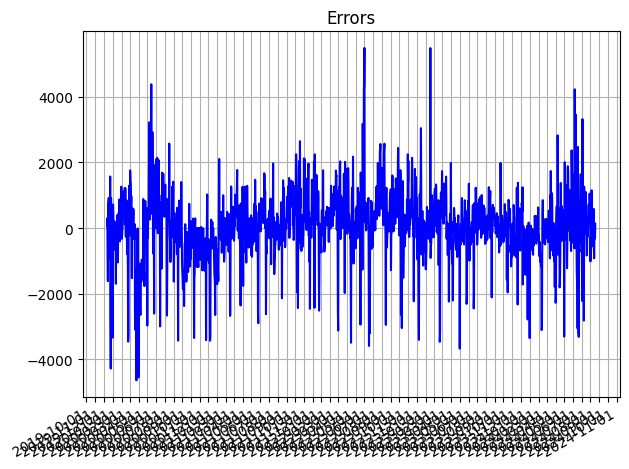

In [148]:
#  Graficar 'error' en el primer subgráfico
plt.plot(df['date'], df['error'], color='blue')
plt.title('Errors')
plt.grid(True)

# Mejorar el formato de la fecha en el eje x
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())
plt.gcf().autofmt_xdate()

# Mostrar la gráfica
plt.tight_layout()
plt.show()

### Variación del feriado

In [149]:
# Cargar el dataset con la variacion de cada feriado
df_variacion = pl.read_parquet("variacion_tipo_feriados.parquet")
print(df_variacion)

shape: (44, 5)
┌───────────────┬───────────────────────────┬──────────────┬──────────────────┬────────────────────┐
│ grupo_feriado ┆ holiday_name              ┆ tipo_feriado ┆ dates            ┆ promedio_variacion │
│ ---           ┆ ---                       ┆ ---          ┆ ---              ┆ ---                │
│ i64           ┆ str                       ┆ i64          ┆ list[list[date]] ┆ f64                │
╞═══════════════╪═══════════════════════════╪══════════════╪══════════════════╪════════════════════╡
│ 1             ┆ Public Sector Half Day    ┆ 2            ┆ [[2022-01-13],   ┆ 14.346576          │
│               ┆                           ┆              ┆ [2022-01-14]]    ┆                    │
│ 2             ┆ End of Ramadan            ┆ 2            ┆ [[2020-05-24],   ┆ -6.851118          │
│               ┆                           ┆              ┆ [2021-05-13], …… ┆                    │
│ 3             ┆ Ramadan Start             ┆ 2            ┆ [[2023-03-23], 

In [150]:
# Asignar 1 como valor por defecto para la columna `promedio_variacion`
df = df.with_columns(pl.lit(1).alias('promedio_variacion'))

# Iterar sobre cada fila en el DataFrame con las variaciones
for row in df_variacion.iter_rows(named=True):
    variacion = row['promedio_variacion']
    fechas = row['dates']  # Es una lista de listas de fechas

    # Iterar sobre las listas de fechas dentro de 'dates'
    for lista_fechas in fechas:
        for fecha in lista_fechas:
            # Asignar la variación a la fecha correspondiente en df_original
            df = df.with_columns(
                pl.when(pl.col('date') == fecha).then(variacion).otherwise(pl.col('promedio_variacion')).alias('promedio_variacion')
            )

# Revisa el DataFrame final
print(df)

shape: (1_724, 7)
┌────────────┬──────┬───────────┬────────────┬────────────────┬──────────────┬────────────────────┐
│ date       ┆ true ┆ pred      ┆ error      ┆ holiday_name   ┆ tipo_feriado ┆ promedio_variacion │
│ ---        ┆ ---  ┆ ---       ┆ ---        ┆ ---            ┆ ---          ┆ ---                │
│ date       ┆ i64  ┆ f64       ┆ f64        ┆ str            ┆ i64          ┆ f64                │
╞════════════╪══════╪═══════════╪════════════╪════════════════╪══════════════╪════════════════════╡
│ 2019-12-12 ┆ 4566 ┆ 4503.0757 ┆ 62.9243    ┆ null           ┆ 0            ┆ 1.0                │
│ 2019-12-13 ┆ 3992 ┆ 3690.1548 ┆ 301.8452   ┆ null           ┆ 0            ┆ 1.0                │
│ 2019-12-14 ┆ 1750 ┆ 2657.3467 ┆ -907.3467  ┆ null           ┆ -1           ┆ 1.0                │
│ 2019-12-15 ┆ 511  ┆ 2125.2124 ┆ -1614.2124 ┆ null           ┆ -1           ┆ 1.0                │
│ 2019-12-16 ┆ 5240 ┆ 4572.128  ┆ 667.872    ┆ null           ┆ 0            ┆ 1.0

#### Tratamos los repetidos

In [151]:
# Filtrar para mantener solo las filas con tipo de feriado 1 si existe al menos uno
df_tipo1 = df.filter(pl.col('tipo_feriado') == 1)
#print(df_tipo1.filter(pl.col('date') == date(2024,6,17)))

# Crear una columna que indique si hay al menos un tipo de feriado 1 para cada fecha
df_min = df.with_columns(
    pl.col('tipo_feriado').min().over('date').alias('tipo_feriado_min')
)
#print(df_min.filter(pl.col('date') == date(2024,6,17)))

# Si no hay tipo de feriado 1, tomar el promedio y concatenar nombres de las filas con tipo de feriado 2
df_tipo2 = df_min.filter(pl.col('tipo_feriado_min') == 2).group_by('date').agg(
    [
        pl.first('true').alias('true'),
        pl.first('pred').alias('pred'),
        pl.first('error').alias('error'),
        #pl.first('holiday_name').alias('holiday_name'),
        pl.col('holiday_name').unique().cast(str).str.join(' / ').alias('holiday_name'),  # Concatenar strings con '/'
        pl.first('tipo_feriado').alias('tipo_feriado'),
        pl.mean('promedio_variacion').alias('promedio_variacion')
    ]
)
#print(df_tipo2.filter(pl.col('date') == date(2020,4,9)))
df_final = pl.concat([df_tipo1, df_tipo2])
print(df_final)

shape: (178, 7)
┌────────────┬──────┬───────────┬────────────┬───────────────────┬──────────────┬──────────────────┐
│ date       ┆ true ┆ pred      ┆ error      ┆ holiday_name      ┆ tipo_feriado ┆ promedio_variaci │
│ ---        ┆ ---  ┆ ---       ┆ ---        ┆ ---               ┆ ---          ┆ on               │
│ date       ┆ i64  ┆ f64       ┆ f64        ┆ str               ┆ i64          ┆ ---              │
│            ┆      ┆           ┆            ┆                   ┆              ┆ f64              │
╞════════════╪══════╪═══════════╪════════════╪═══════════════════╪══════════════╪══════════════════╡
│ 2019-12-25 ┆ 231  ┆ 4509.064  ┆ -4278.064  ┆ Christmas Day     ┆ 1            ┆ 75.138578        │
│ 2019-12-31 ┆ 1460 ┆ 3858.5183 ┆ -2398.5183 ┆ New Year's Eve    ┆ 1            ┆ 54.880224        │
│ 2020-01-01 ┆ 232  ┆ 3568.2732 ┆ -3336.2732 ┆ New Year's Day    ┆ 1            ┆ 74.926052        │
│ 2020-02-24 ┆ 1180 ┆ 4639.808  ┆ -3459.808  ┆ Carnival / Shrove ┆ 1       

In [152]:
# Filtrar filas que están en el primer DataFrame pero no en el segundo
df_faltantes = df.join(df_final, on='date', how='anti')
df_concatenado = pl.concat([df_final, df_faltantes])
df = df_concatenado.sort('date')
print(df)
print(len(df) == len(df['date'].unique())) #ya no tenemos repetidos

shape: (1_712, 7)
┌────────────┬──────┬───────────┬────────────┬────────────────┬──────────────┬────────────────────┐
│ date       ┆ true ┆ pred      ┆ error      ┆ holiday_name   ┆ tipo_feriado ┆ promedio_variacion │
│ ---        ┆ ---  ┆ ---       ┆ ---        ┆ ---            ┆ ---          ┆ ---                │
│ date       ┆ i64  ┆ f64       ┆ f64        ┆ str            ┆ i64          ┆ f64                │
╞════════════╪══════╪═══════════╪════════════╪════════════════╪══════════════╪════════════════════╡
│ 2019-12-12 ┆ 4566 ┆ 4503.0757 ┆ 62.9243    ┆ null           ┆ 0            ┆ 1.0                │
│ 2019-12-13 ┆ 3992 ┆ 3690.1548 ┆ 301.8452   ┆ null           ┆ 0            ┆ 1.0                │
│ 2019-12-14 ┆ 1750 ┆ 2657.3467 ┆ -907.3467  ┆ null           ┆ -1           ┆ 1.0                │
│ 2019-12-15 ┆ 511  ┆ 2125.2124 ┆ -1614.2124 ┆ null           ┆ -1           ┆ 1.0                │
│ 2019-12-16 ┆ 5240 ┆ 4572.128  ┆ 667.872    ┆ null           ┆ 0            ┆ 1.0

## Predicción de errores

In [23]:
X_train, X_test, y_train, y_test = split(['pred', 'tipo_feriado', 'promedio_variacion'], 'error', date(2023,7,31), df)
#se entrena con 2 años y testea con el 5% o un mes pero aca vemos solo feriados así que está bien
y_pred_feriados = lgbm_model(X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/home/mutt/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mutt/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mutt/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mutt/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed w

/home/mutt/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mutt/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mutt/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mutt/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed w

Mejores parámetros encontrados: {'num_leaves': 30, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.05000000000000001}


/home/mutt/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### Evaluación del modelo

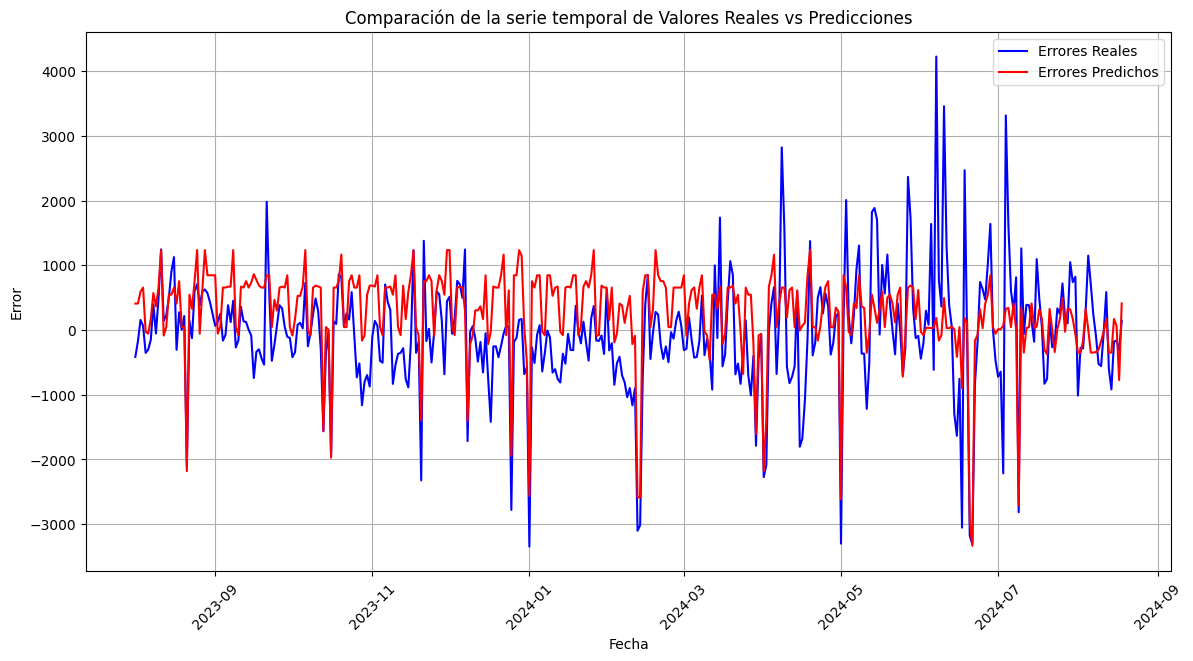

In [24]:
# Crear una serie de tiempo para las fechas correspondientes a y_test
dates_test = df.filter(pl.col('date') > date(2023,7,31)).select('date').to_numpy().ravel()

# Graficar la serie temporal
plt.figure(figsize=(14, 7))
plt.plot(dates_test, y_test, label='Errores Reales', color='blue')
plt.plot(dates_test, y_pred_feriados, label='Errores Predichos', color='red')

plt.xlabel('Fecha')
plt.ylabel('Error')
plt.title('Comparación de la serie temporal de Valores Reales vs Predicciones')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

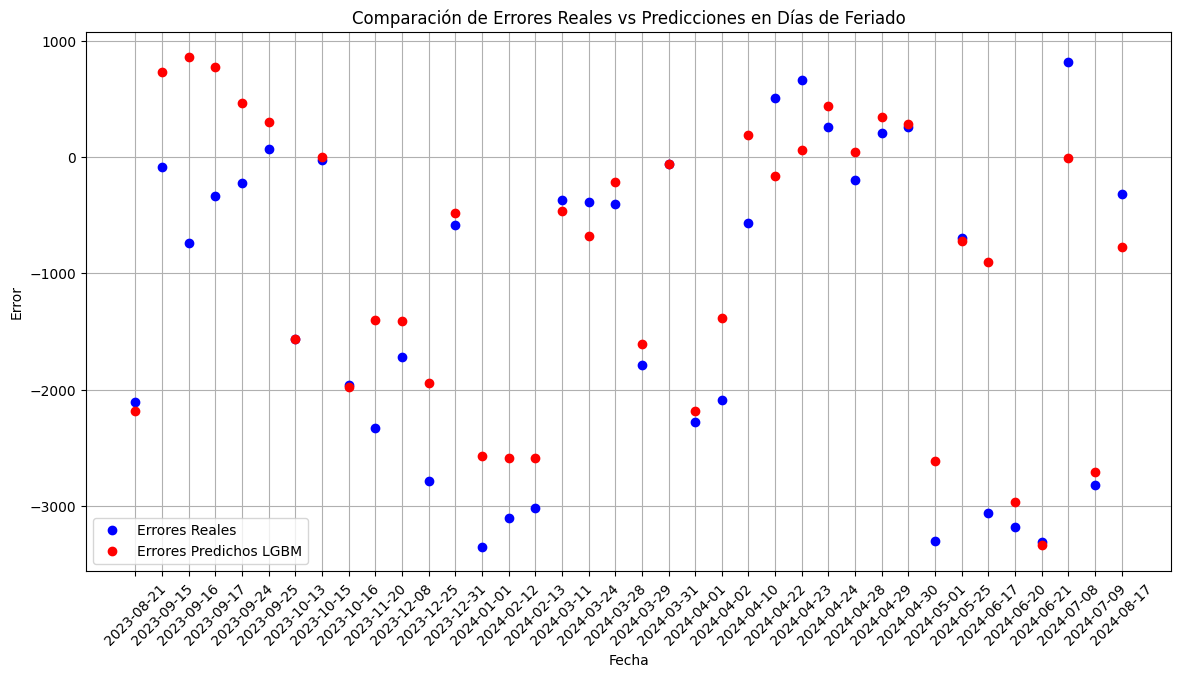

In [25]:
df_results_feriados = df_con_resultados(df, y_test, y_pred_feriados, date(2023,7,31), 'feriados')
# Hacer un join para obtener solo los días de feriado (tipo_feriado == 1 o 2)
df_results_solo_feriados = df_results_feriados.join(
    df[['date', 'tipo_feriado']].filter((pl.col('tipo_feriado') == 1) | (pl.col('tipo_feriado') == 2)), 
    on='date', 
    how='inner'
)
plot_results(df_results_solo_feriados, 'y_test', 'y_pred_feriados')

#### Comparamos para ver performance

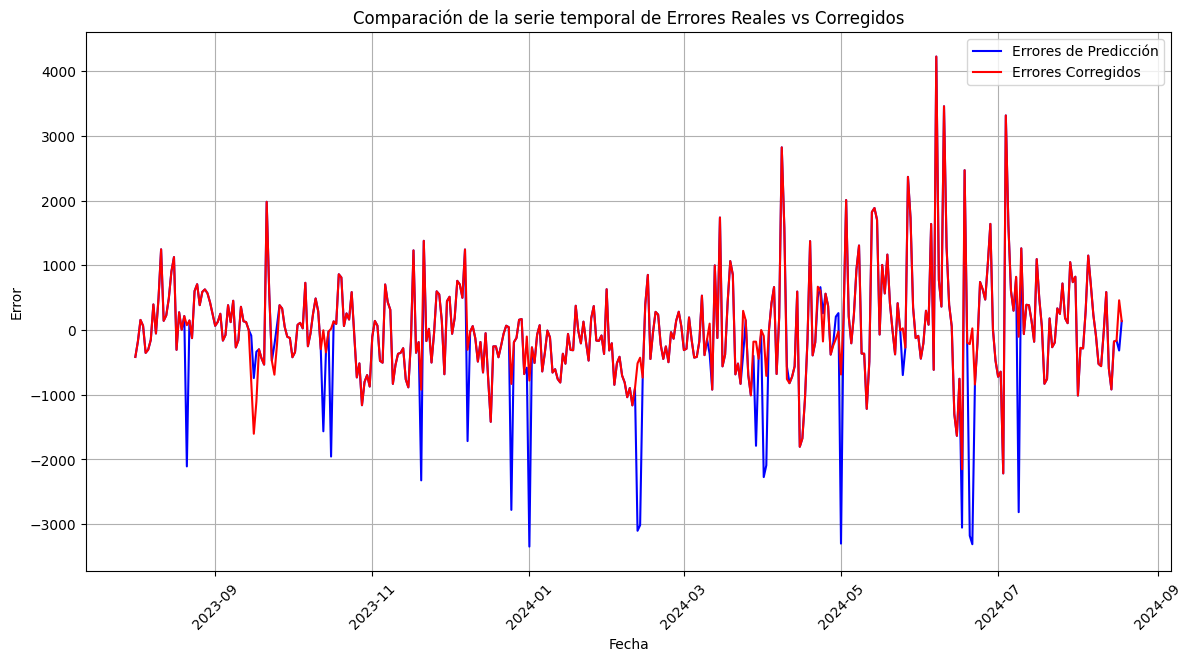

In [26]:
df_comparation_feriados = df_comparation_para_feriados(df, date(2023,7,31), df_results_solo_feriados, 'feriados')
#print(df_comparation_feriados)
plot_errors(df_comparation_feriados, 'feriados')

In [27]:
print(df_comparation_feriados['error'].describe())

shape: (9, 2)
┌────────────┬────────────┐
│ statistic  ┆ value      │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ count      ┆ 384.0      │
│ null_count ┆ 0.0        │
│ mean       ┆ -59.734147 │
│ std        ┆ 920.023904 │
│ min        ┆ -3350.0415 │
│ 25%        ┆ -440.2402  │
│ 50%        ┆ -71.31     │
│ 75%        ┆ 368.273    │
│ max        ┆ 4226.332   │
└────────────┴────────────┘


In [28]:
print(df_comparation_feriados['error_corregido_feriados'].describe())

shape: (9, 2)
┌────────────┬────────────┐
│ statistic  ┆ value      │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ count      ┆ 384.0      │
│ null_count ┆ 0.0        │
│ mean       ┆ 31.479029  │
│ std        ┆ 754.863879 │
│ min        ┆ -2218.672  │
│ 25%        ┆ -389.5314  │
│ 50%        ┆ -56.96265  │
│ 75%        ┆ 370.1028   │
│ max        ┆ 4226.332   │
└────────────┴────────────┘


##### Agregamos fin de semana

In [29]:
df_results

date,pred,calculated_at
date,f64,str
2019-12-12,4503.0757,"""2024-08-22 02:05:19.709968"""
2019-12-13,3690.1548,"""2024-08-22 02:05:19.709968"""
2019-12-14,2657.3467,"""2024-08-22 02:05:19.709968"""
2019-12-15,2125.2124,"""2024-08-22 02:05:19.709968"""
2019-12-16,4572.128,"""2024-08-22 02:05:19.709968"""
…,…,…
2024-08-14,6057.114,"""2024-08-22 08:11:39.737303"""
2024-08-15,5430.66,"""2024-08-22 00:37:05.037591"""
2024-08-16,5251.4424,"""2024-08-22 00:37:05.037591"""


In [30]:
df_results_findes = df_results_feriados.join(
    df[['date', 'tipo_feriado']].filter(pl.col('tipo_feriado') != 0), 
    on='date', 
    how='inner'
)
df_results_findes = df_results_findes.rename({"y_pred_feriados": "y_pred_findes"})
print(df_results_findes)
#plot_results(df_results_findes, 'y_test', 'y_pred_feriados')

shape: (138, 4)
┌────────────┬───────────┬───────────────┬──────────────┐
│ date       ┆ y_test    ┆ y_pred_findes ┆ tipo_feriado │
│ ---        ┆ ---       ┆ ---           ┆ ---          │
│ date       ┆ f64       ┆ f64           ┆ i64          │
╞════════════╪═══════════╪═══════════════╪══════════════╡
│ 2023-08-05 ┆ -355.2804 ┆ -28.616077    ┆ -1           │
│ 2023-08-06 ┆ -304.7046 ┆ -57.959037    ┆ -1           │
│ 2023-08-12 ┆ 140.4397  ┆ -86.683514    ┆ -1           │
│ 2023-08-13 ┆ 224.5967  ┆ 42.96643      ┆ -1           │
│ 2023-08-19 ┆ 3.7073    ┆ 43.343823     ┆ -1           │
│ …          ┆ …         ┆ …             ┆ …            │
│ 2024-08-04 ┆ 294.13867 ┆ 324.208221    ┆ -1           │
│ 2024-08-10 ┆ -559.8755 ┆ -172.822483   ┆ -1           │
│ 2024-08-11 ┆ -39.1438  ┆ -25.597852    ┆ -1           │
│ 2024-08-17 ┆ -318.5123 ┆ -776.607483   ┆ 2            │
│ 2024-08-18 ┆ 136.66162 ┆ 409.670626    ┆ -1           │
└────────────┴───────────┴───────────────┴──────────────

In [31]:
df_comparation_findes =  df_comparation_para_feriados(df, date(2023,7,31), df_results_findes, 'findes')
#print(df_comparation_findes)
#plot_errors(df_comparation_findes, 'findes')

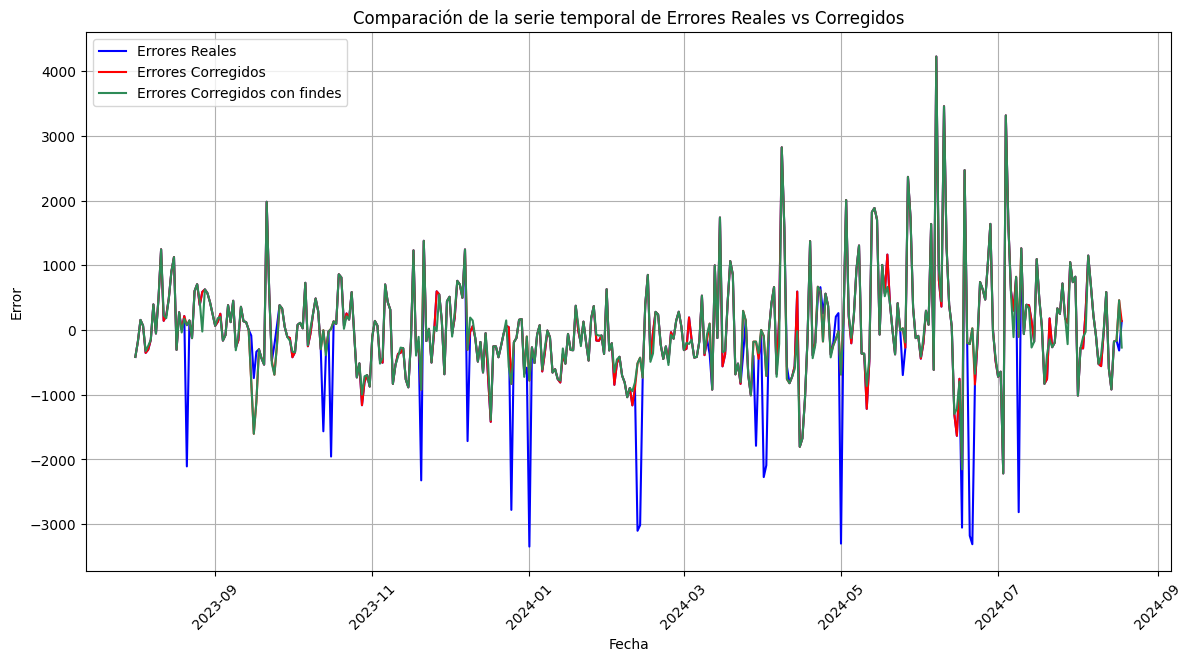

In [32]:
# Graficar la serie temporal
plt.figure(figsize=(14, 7))
plt.plot(df_comparation_feriados['date'], df_comparation_feriados['error'], label='Errores Reales', color='blue')
plt.plot(df_comparation_feriados['date'], df_comparation_feriados['error_corregido_feriados'], label='Errores Corregidos', color='red')
plt.plot(df_comparation_findes['date'], df_comparation_findes['error_corregido_findes'], label='Errores Corregidos con findes', color='seagreen')

plt.xlabel('Fecha')
plt.ylabel('Error')
plt.title('Comparación de la serie temporal de Errores Reales vs Corregidos')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [33]:
print(df_comparation_findes['error_corregido_findes'].describe())

shape: (9, 2)
┌────────────┬─────────────┐
│ statistic  ┆ value       │
│ ---        ┆ ---         │
│ str        ┆ f64         │
╞════════════╪═════════════╡
│ count      ┆ 384.0       │
│ null_count ┆ 0.0         │
│ mean       ┆ 27.313832   │
│ std        ┆ 743.961221  │
│ min        ┆ -2218.672   │
│ 25%        ┆ -387.053017 │
│ 50%        ┆ -79.857     │
│ 75%        ┆ 342.6238    │
│ max        ┆ 4226.332    │
└────────────┴─────────────┘


# Días no laborables de corrido

In [34]:
# Cargar el dataset con la variacion de cada feriado
df_dias_laborables = pl.read_csv("cantidad_dias_no_laborables.csv")
df_dias_laborables = df_dias_laborables.with_columns(pl.col("date").str.strptime(pl.Date, "%Y-%m-%d"))
print(df_dias_laborables)

shape: (1_825, 7)
┌────────────┬───────────────┬────────────┬───────────────┬─────────┬──────────────┬───────────────┐
│ date       ┆ cantidad_entr ┆ is_holiday ┆ holiday_name  ┆ weekday ┆ tipo_feriado ┆ cantidad_dias │
│ ---        ┆ egas          ┆ ---        ┆ ---           ┆ ---     ┆ ---          ┆ _no_laborable │
│ date       ┆ ---           ┆ bool       ┆ str           ┆ i64     ┆ i64          ┆ s             │
│            ┆ i64           ┆            ┆               ┆         ┆              ┆ ---           │
│            ┆               ┆            ┆               ┆         ┆              ┆ i64           │
╞════════════╪═══════════════╪════════════╪═══════════════╪═════════╪══════════════╪═══════════════╡
│ 2019-09-05 ┆ 2769          ┆ false      ┆ null          ┆ 4       ┆ 0            ┆ 0             │
│ 2019-09-06 ┆ 8474          ┆ false      ┆ null          ┆ 5       ┆ 0            ┆ 0             │
│ 2019-09-07 ┆ 613           ┆ false      ┆ null          ┆ 6       ┆ -1 

In [35]:
print(len(df_dias_laborables['date'].unique()) == len(df_dias_laborables))

False


#### Tratamos repetidos

In [36]:
print(df)
    

shape: (1_712, 7)
┌────────────┬──────┬───────────┬────────────┬────────────────┬──────────────┬────────────────────┐
│ date       ┆ true ┆ pred      ┆ error      ┆ holiday_name   ┆ tipo_feriado ┆ promedio_variacion │
│ ---        ┆ ---  ┆ ---       ┆ ---        ┆ ---            ┆ ---          ┆ ---                │
│ date       ┆ i64  ┆ f64       ┆ f64        ┆ str            ┆ i64          ┆ f64                │
╞════════════╪══════╪═══════════╪════════════╪════════════════╪══════════════╪════════════════════╡
│ 2019-12-12 ┆ 4566 ┆ 4503.0757 ┆ 62.9243    ┆ null           ┆ 0            ┆ 1.0                │
│ 2019-12-13 ┆ 3992 ┆ 3690.1548 ┆ 301.8452   ┆ null           ┆ 0            ┆ 1.0                │
│ 2019-12-14 ┆ 1750 ┆ 2657.3467 ┆ -907.3467  ┆ null           ┆ -1           ┆ 1.0                │
│ 2019-12-15 ┆ 511  ┆ 2125.2124 ┆ -1614.2124 ┆ null           ┆ -1           ┆ 1.0                │
│ 2019-12-16 ┆ 5240 ┆ 4572.128  ┆ 667.872    ┆ null           ┆ 0            ┆ 1.0

In [37]:
#### Hacemos join con el df que teníamos donde ya tratamos los feriados
# Primero eliminamos fechas duplicadas en df_dias_laborables, ya que el valor en columna 'cantidad_dias_no_laborables' es el mismo
df_dias_laborables_unique = df_dias_laborables.unique(subset=["date"], keep="first")
df_laborables = df.join(df_dias_laborables_unique[['date', 'cantidad_dias_no_laborables']], on="date", how="left")
print(df_laborables)
print(len(df_laborables['date'].unique()) == len(df_laborables))

shape: (1_712, 8)
┌────────────┬──────┬───────────┬────────────┬─────────────┬─────────────┬────────────┬────────────┐
│ date       ┆ true ┆ pred      ┆ error      ┆ holiday_nam ┆ tipo_feriad ┆ promedio_v ┆ cantidad_d │
│ ---        ┆ ---  ┆ ---       ┆ ---        ┆ e           ┆ o           ┆ ariacion   ┆ ias_no_lab │
│ date       ┆ i64  ┆ f64       ┆ f64        ┆ ---         ┆ ---         ┆ ---        ┆ orables    │
│            ┆      ┆           ┆            ┆ str         ┆ i64         ┆ f64        ┆ ---        │
│            ┆      ┆           ┆            ┆             ┆             ┆            ┆ i64        │
╞════════════╪══════╪═══════════╪════════════╪═════════════╪═════════════╪════════════╪════════════╡
│ 2019-12-12 ┆ 4566 ┆ 4503.0757 ┆ 62.9243    ┆ null        ┆ 0           ┆ 1.0        ┆ 0          │
│ 2019-12-13 ┆ 3992 ┆ 3690.1548 ┆ 301.8452   ┆ null        ┆ 0           ┆ 1.0        ┆ 0          │
│ 2019-12-14 ┆ 1750 ┆ 2657.3467 ┆ -907.3467  ┆ null        ┆ -1          

## Predicción de errores

In [38]:
X_train, X_test, y_train, y_test = split(['pred', 'tipo_feriado', 'promedio_variacion', 'cantidad_dias_no_laborables'], 'error', date(2023,7,31), df_laborables)
#se entrena con 2 años y testea con el 5% o un mes pero aca vemos solo feriados así que está bien
y_pred_laborables = lgbm_model(X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/home/mutt/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mutt/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mutt/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mutt/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed w

/home/mutt/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mutt/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mutt/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mutt/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed w

Mejores parámetros encontrados: {'num_leaves': 30, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.05000000000000001}


/home/mutt/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [39]:
df_results_laborables = df_con_resultados(df_laborables, y_test, y_pred_laborables, date(2023,7,31), 'laborables')
# Hacer un join para obtener solo los días de feriado (tipo_feriado == 1 o 2)
df_results_laborables_solo_feriados = df_results_laborables.join(
    df[['date', 'tipo_feriado']].filter((pl.col('tipo_feriado') == 1) | (pl.col('tipo_feriado') == 2)), 
    on='date', 
    how='inner'
)
#plot_results(df_results_solo_feriados, 'y_test', 'y_pred_feriados')

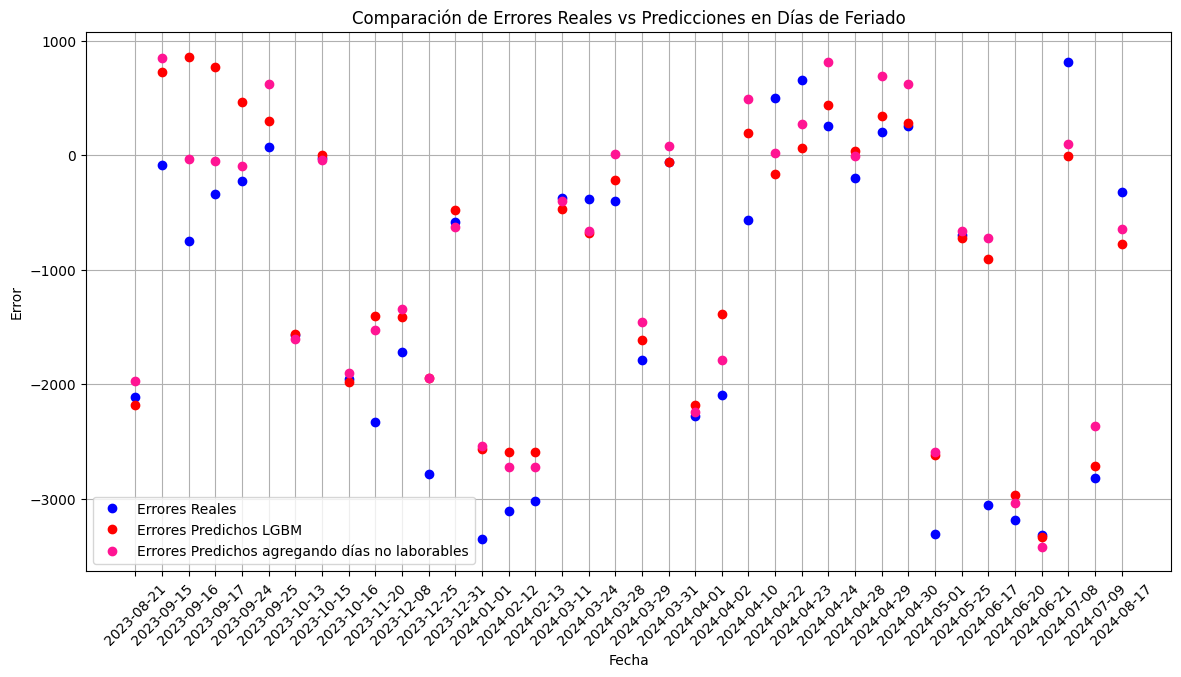

In [40]:
# Crear un índice para cada fecha
indice_laborables = df_results_laborables_solo_feriados.with_columns([
    pl.arange(0, df_results_laborables_solo_feriados.height).alias('index')
])

plt.figure(figsize=(14, 7))

# Graficar los valores de y_test y las predicciones usando el índice en el eje X
plt.plot(indice_laborables['index'], indice_laborables['y_test'], label='Errores Reales', color='blue', marker='o', linestyle='None')
plt.plot(indice_laborables['index'], df_results_solo_feriados['y_pred_feriados'], label='Errores Predichos LGBM', color='red', marker='o', linestyle='None')
plt.plot(indice_laborables['index'], indice_laborables['y_pred_laborables'], label='Errores Predichos agregando días no laborables', color='deeppink', marker='o', linestyle='None')

# Reemplazar las etiquetas del eje X por las fechas correspondientes
plt.xticks(indice_laborables['index'], indice_laborables['date'], rotation=45)

plt.xlabel('Fecha')
plt.ylabel('Error')
plt.title('Comparación de Errores Reales vs Predicciones en Días de Feriado')
plt.legend()
plt.grid(True)
plt.show()

#### Veamos si mejoró

In [41]:
### Lo anterior fue para el gráfico, pero para análisis tengamos en cuenta los fin de semana también
df_results_laborables = df_results_laborables.join(
    df[['date', 'tipo_feriado']].filter(pl.col('tipo_feriado') != 0), 
    on='date', 
    how='inner'
)
df_comparation_laborables = df_comparation_para_feriados(df, date(2023,7,31), df_results_laborables, 'laborables')
#print(df_comparation_feriados)
#plot_errors(df_comparation_laborables, 'laborables')

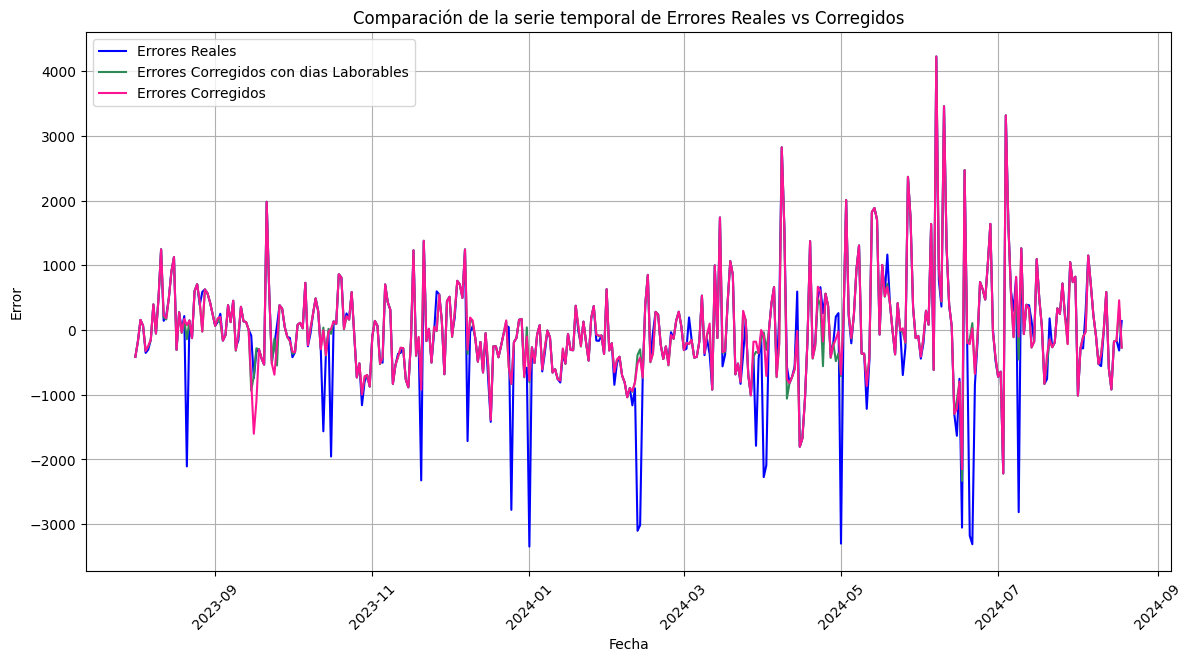

In [42]:
# Graficar la serie temporal
plt.figure(figsize=(14, 7))
plt.plot(df_comparation_laborables['date'], df_comparation_laborables['error'], label='Errores Reales', color='blue')
plt.plot(df_comparation_laborables['date'], df_comparation_laborables['error_corregido_laborables'], label='Errores Corregidos con dias Laborables', color='seagreen')
plt.plot(df_comparation_findes['date'], df_comparation_findes['error_corregido_findes'], label='Errores Corregidos', color='deeppink')

plt.xlabel('Fecha')
plt.ylabel('Error')
plt.title('Comparación de la serie temporal de Errores Reales vs Corregidos')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [43]:
print(df_comparation_findes['error_corregido_findes'].describe())

shape: (9, 2)
┌────────────┬─────────────┐
│ statistic  ┆ value       │
│ ---        ┆ ---         │
│ str        ┆ f64         │
╞════════════╪═════════════╡
│ count      ┆ 384.0       │
│ null_count ┆ 0.0         │
│ mean       ┆ 27.313832   │
│ std        ┆ 743.961221  │
│ min        ┆ -2218.672   │
│ 25%        ┆ -387.053017 │
│ 50%        ┆ -79.857     │
│ 75%        ┆ 342.6238    │
│ max        ┆ 4226.332    │
└────────────┴─────────────┘


In [44]:
print(df_comparation_laborables['error_corregido_laborables'].describe())

shape: (9, 2)
┌────────────┬──────────────┐
│ statistic  ┆ value        │
│ ---        ┆ ---          │
│ str        ┆ f64          │
╞════════════╪══════════════╡
│ count      ┆ 384.0        │
│ null_count ┆ 0.0          │
│ mean       ┆ 24.592915    │
│ std        ┆ 739.7647     │
│ min        ┆ -2334.928161 │
│ 25%        ┆ -397.808629  │
│ 50%        ┆ -89.838      │
│ 75%        ┆ 332.708      │
│ max        ┆ 4226.332     │
└────────────┴──────────────┘


Parece haber mejorado apenas con la cantidad de días no laborables de corrido.

# Features ventas

In [45]:
print(df)

shape: (1_712, 7)
┌────────────┬──────┬───────────┬────────────┬────────────────┬──────────────┬────────────────────┐
│ date       ┆ true ┆ pred      ┆ error      ┆ holiday_name   ┆ tipo_feriado ┆ promedio_variacion │
│ ---        ┆ ---  ┆ ---       ┆ ---        ┆ ---            ┆ ---          ┆ ---                │
│ date       ┆ i64  ┆ f64       ┆ f64        ┆ str            ┆ i64          ┆ f64                │
╞════════════╪══════╪═══════════╪════════════╪════════════════╪══════════════╪════════════════════╡
│ 2019-12-12 ┆ 4566 ┆ 4503.0757 ┆ 62.9243    ┆ null           ┆ 0            ┆ 1.0                │
│ 2019-12-13 ┆ 3992 ┆ 3690.1548 ┆ 301.8452   ┆ null           ┆ 0            ┆ 1.0                │
│ 2019-12-14 ┆ 1750 ┆ 2657.3467 ┆ -907.3467  ┆ null           ┆ -1           ┆ 1.0                │
│ 2019-12-15 ┆ 511  ┆ 2125.2124 ┆ -1614.2124 ┆ null           ┆ -1           ┆ 1.0                │
│ 2019-12-16 ┆ 5240 ┆ 4572.128  ┆ 667.872    ┆ null           ┆ 0            ┆ 1.0

In [46]:
# Cargar el dataset con la variacion de cada feriado
df_ventas = pl.read_csv("cantidad_ventas.csv")
df_ventas = df_ventas.with_columns(pl.col("date").str.strptime(pl.Date, "%Y-%m-%d"))
print(df_ventas)

shape: (1_779, 3)
┌────────────┬───────────────────┬─────────────────┐
│ date       ┆ cantidad_entregas ┆ cantidad_ventas │
│ ---        ┆ ---               ┆ ---             │
│ date       ┆ i64               ┆ i64             │
╞════════════╪═══════════════════╪═════════════════╡
│ 2019-09-05 ┆ 2769              ┆ 183341          │
│ 2019-09-06 ┆ 8474              ┆ 207252          │
│ 2019-09-07 ┆ 613               ┆ 189266          │
│ 2019-09-08 ┆ 346               ┆ 166045          │
│ 2019-09-09 ┆ 4814              ┆ 204670          │
│ …          ┆ …                 ┆ …               │
│ 2024-07-14 ┆ 539               ┆ 132314          │
│ 2024-07-15 ┆ 4880              ┆ 216373          │
│ 2024-07-16 ┆ 6048              ┆ 198518          │
│ 2024-07-17 ┆ 5371              ┆ 201872          │
│ 2024-07-18 ┆ 3562              ┆ 215586          │
└────────────┴───────────────────┴─────────────────┘


In [47]:
df_ventas = df_laborables.join(df_ventas[['date', 'cantidad_ventas']], on="date", how="left")
df_ventas = df_ventas.filter(pl.col('date') <= date(2024,7,18))
print(df_ventas)

shape: (1_681, 9)
┌────────────┬──────┬───────────┬────────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ date       ┆ true ┆ pred      ┆ error      ┆ … ┆ tipo_feria ┆ promedio_v ┆ cantidad_ ┆ cantidad_ │
│ ---        ┆ ---  ┆ ---       ┆ ---        ┆   ┆ do         ┆ ariacion   ┆ dias_no_l ┆ ventas    │
│ date       ┆ i64  ┆ f64       ┆ f64        ┆   ┆ ---        ┆ ---        ┆ aborables ┆ ---       │
│            ┆      ┆           ┆            ┆   ┆ i64        ┆ f64        ┆ ---       ┆ i64       │
│            ┆      ┆           ┆            ┆   ┆            ┆            ┆ i64       ┆           │
╞════════════╪══════╪═══════════╪════════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 2019-12-12 ┆ 4566 ┆ 4503.0757 ┆ 62.9243    ┆ … ┆ 0          ┆ 1.0        ┆ 0         ┆ 245256    │
│ 2019-12-13 ┆ 3992 ┆ 3690.1548 ┆ 301.8452   ┆ … ┆ 0          ┆ 1.0        ┆ 0         ┆ 235333    │
│ 2019-12-14 ┆ 1750 ┆ 2657.3467 ┆ -907.3467  ┆ … ┆ -1         ┆ 1.0      

## Predicción de errores

In [48]:
X_train, X_test, y_train, y_test = split(['pred', 'tipo_feriado', 'promedio_variacion', 'cantidad_ventas'], 'error', date(2024,5,31), df_ventas)
#se entrena con 2 años y testea con el 5% o un mes pero aca vemos solo feriados así que está bien (preguntar ya que aca no son solo feriados)
y_pred_ventas = lgbm_model(X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/home/mutt/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mutt/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mutt/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mutt/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed w

/home/mutt/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mutt/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mutt/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mutt/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed w

Mejores parámetros encontrados: {'num_leaves': 30, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.05000000000000001}


/home/mutt/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [49]:
df_results_ventas = df_con_resultados(df_ventas, y_test, y_pred_ventas, date(2024,5,31), 'ventas')

#### Veamos si mejoró

In [50]:
df_comparation_ventas = df_comparation(df, date(2024,5,31), df_results_ventas, 'ventas')

In [51]:
df_comparation_ventas['date'].max()

datetime.date(2024, 8, 18)

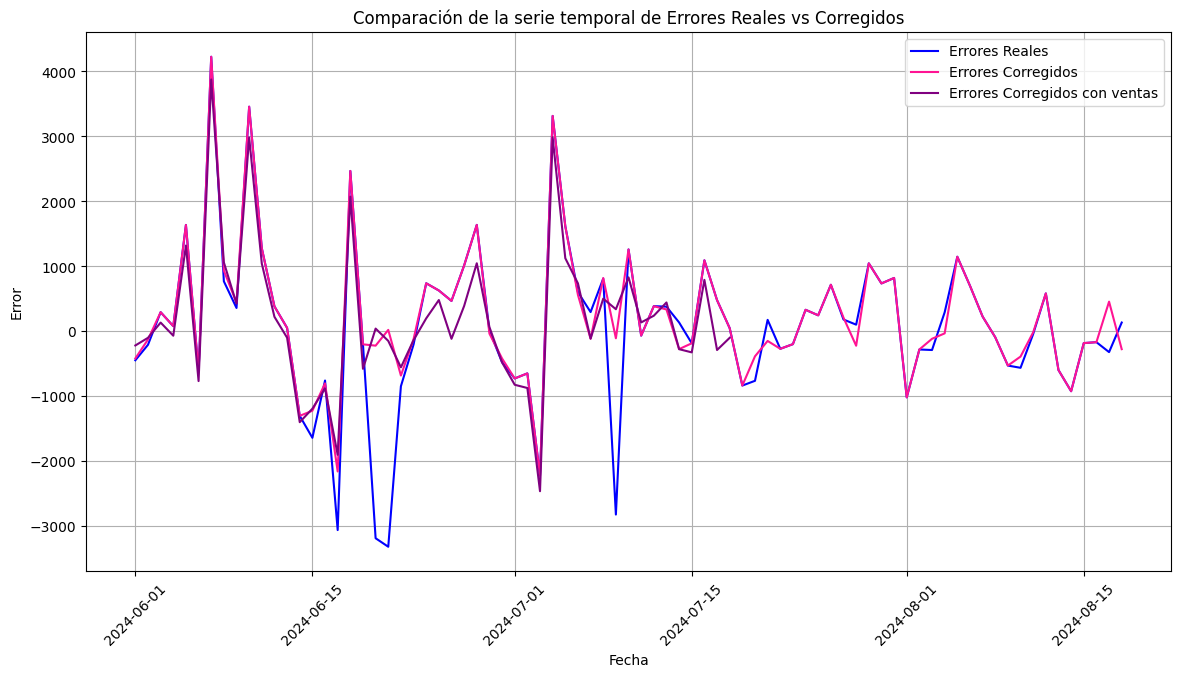

In [52]:
# Graficar la serie temporal
plt.figure(figsize=(14, 7))
plt.plot(df_comparation_ventas['date'], df_comparation_ventas['error'], label='Errores Reales', color='blue')
plt.plot(df_comparation_ventas['date'], df_comparation_findes.filter(pl.col('date') > date(2024,5,31))['error_corregido_findes'], label='Errores Corregidos', color='deeppink')
plt.plot(df_comparation_ventas['date'], df_comparation_ventas['error_corregido_ventas'], label='Errores Corregidos con ventas', color='purple')

plt.xlabel('Fecha')
plt.ylabel('Error')
plt.title('Comparación de la serie temporal de Errores Reales vs Corregidos')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [53]:
print(df_comparation_findes.filter(pl.col('date') > date(2024,5,31))['error_corregido_findes'].describe())

shape: (9, 2)
┌────────────┬─────────────┐
│ statistic  ┆ value       │
│ ---        ┆ ---         │
│ str        ┆ f64         │
╞════════════╪═════════════╡
│ count      ┆ 79.0        │
│ null_count ┆ 0.0         │
│ mean       ┆ 224.098973  │
│ std        ┆ 1046.993889 │
│ min        ┆ -2218.672   │
│ 25%        ┆ -272.202126 │
│ 50%        ┆ -13.545948  │
│ 75%        ┆ 702.839     │
│ max        ┆ 4226.332    │
└────────────┴─────────────┘


In [54]:
df_comparation_ventas['error_corregido_ventas']

error_corregido_ventas
f64
-216.118972
-98.290225
136.015165
-65.945952
1321.27967
…
null
null
null


In [55]:
print(df_comparation_ventas.filter(pl.col('date') > date(2024,5,31))['error_corregido_ventas'].describe())

shape: (9, 2)
┌────────────┬──────────────┐
│ statistic  ┆ value        │
│ ---        ┆ ---          │
│ str        ┆ f64          │
╞════════════╪══════════════╡
│ count      ┆ 48.0         │
│ null_count ┆ 31.0         │
│ mean       ┆ 201.840626   │
│ std        ┆ 1146.673196  │
│ min        ┆ -2458.750444 │
│ 25%        ┆ -286.02939   │
│ 50%        ┆ 67.110094    │
│ 75%        ┆ 504.334465   │
│ max        ┆ 3875.691464  │
└────────────┴──────────────┘


# Predicciones Claro

In [56]:
# Cargar el dataset con la predicción de las entregas de claro y llevarlos al formato nuestro
df_results_claro = pl.read_csv("predicciones_claro.csv") 
#df_claro = df_claro.with_columns(pl.col("FECHA").str.strptime(pl.Date, "%Y-%m-%d"))
df_results_claro = df_results_claro.with_columns(
    pl.col("FECHA")
    .str.strptime(pl.Datetime, format="%Y-%m-%d %H:%M:%S.%f", strict=False)  # Convertir a datetime
    .dt.truncate("1d")  # Truncar la parte de tiempo
    .cast(pl.Date)  # Convertir a formato Date (solo fecha)
)

# # Mostrar las primeras filas para verificar la carga
print(df_results_claro)

shape: (41, 11)
┌─────────┬────────────┬──────┬────────┬───┬────────┬────────┬────────┬────────┐
│ CENTRO  ┆ FECHA      ┆ PRED ┆ PRED_1 ┆ … ┆ PRED_5 ┆ PRED_6 ┆ PRED_7 ┆ PRED_8 │
│ ---     ┆ ---        ┆ ---  ┆ ---    ┆   ┆ ---    ┆ ---    ┆ ---    ┆ ---    │
│ str     ┆ date       ┆ i64  ┆ i64    ┆   ┆ i64    ┆ i64    ┆ i64    ┆ i64    │
╞═════════╪════════════╪══════╪════════╪═══╪════════╪════════╪════════╪════════╡
│ GENERAL ┆ 2023-12-28 ┆ 3321 ┆ 2822   ┆ … ┆ 3460   ┆ 3897   ┆ 3467   ┆ 3244   │
│ GENERAL ┆ 2024-01-04 ┆ 3708 ┆ 3684   ┆ … ┆ 3980   ┆ 3552   ┆ 3672   ┆ 3430   │
│ GENERAL ┆ 2024-01-11 ┆ 3414 ┆ 3256   ┆ … ┆ 3598   ┆ 3521   ┆ 3103   ┆ 3171   │
│ GENERAL ┆ 2024-01-18 ┆ 3543 ┆ 3382   ┆ … ┆ 3744   ┆ 3789   ┆ 3714   ┆ 3141   │
│ GENERAL ┆ 2024-01-25 ┆ 3282 ┆ 3204   ┆ … ┆ 3717   ┆ 3802   ┆ 3826   ┆ 3558   │
│ …       ┆ …          ┆ …    ┆ …      ┆ … ┆ …      ┆ …      ┆ …      ┆ …      │
│ GENERAL ┆ 2024-09-05 ┆ 5370 ┆ 4995   ┆ … ┆ 5268   ┆ 5318   ┆ 5116   ┆ 4877   │
│ GENERAL ┆ 

/tmp/ipykernel_5439/2756855234.py:5: ChronoFormatWarning: Detected the pattern `.%f` in the chrono format string. This pattern should not be used to parse values after a decimal point. Use `%.f` instead. See the full specification: https://docs.rs/chrono/latest/chrono/format/strftime
  pl.col("FECHA")


In [57]:
# Crear una lista para almacenar las nuevas filas en formato `date | pred`
nuevas_filas = []

# Iterar sobre cada fila del DataFrame original
for idx, row in enumerate(df_results_claro.iter_rows(named=True)):
    fecha_inicial = row["FECHA"]  # Convertir a formato datetime
    
    # Si es la primera semana, usar todas las predicciones (PRED, PRED_1, ..., PRED_8)
    if idx == 0:
        start_pred = 0  # Comienza desde PRED
    else:
        start_pred = 2  # Omitir PRED y PRED_1 en las semanas siguientes porque estan calculadas la semana anterior

    # Iterar sobre las predicciones relevantes para cada fila
    for i in range(start_pred, 9):
        fecha_predicha = fecha_inicial + timedelta(days=i)
        pred = row[f"PRED_{i}" if i > 0 else "PRED"]  # Obtener el valor de predicción

        # Agregar la nueva fila (fecha, predicción) a la lista
        nuevas_filas.append({"date": fecha_predicha, "pred": pred})

# Crear el nuevo DataFrame en formato `date | pred`
df_claro_pred = pl.DataFrame(nuevas_filas)

max_date = date(2024, 8, 18)
df_claro_pred = df_claro_pred.filter(pl.col('date') <= max_date)

# Mostrar el resultado
print(df_claro_pred)

shape: (235, 2)
┌────────────┬──────┐
│ date       ┆ pred │
│ ---        ┆ ---  │
│ date       ┆ i64  │
╞════════════╪══════╡
│ 2023-12-28 ┆ 3321 │
│ 2023-12-29 ┆ 2822 │
│ 2023-12-30 ┆ 1076 │
│ 2023-12-31 ┆ 123  │
│ 2024-01-01 ┆ 3339 │
│ …          ┆ …    │
│ 2024-08-14 ┆ 6094 │
│ 2024-08-15 ┆ 5668 │
│ 2024-08-16 ┆ 5141 │
│ 2024-08-17 ┆ 2198 │
│ 2024-08-18 ┆ 796  │
└────────────┴──────┘


In [58]:
### Le agregamos los valores reales
df_claro = df_true.join(df_claro_pred[['date', 'pred']], on="date", how="inner")
df_claro = df_claro.rename({"cantidad_entregas": "true"})
print(df_claro)

shape: (235, 3)
┌────────────┬──────┬──────┐
│ date       ┆ true ┆ pred │
│ ---        ┆ ---  ┆ ---  │
│ date       ┆ i64  ┆ i64  │
╞════════════╪══════╪══════╡
│ 2023-12-28 ┆ 2977 ┆ 3321 │
│ 2023-12-29 ┆ 2717 ┆ 2822 │
│ 2023-12-30 ┆ 998  ┆ 1076 │
│ 2023-12-31 ┆ 265  ┆ 123  │
│ 2024-01-01 ┆ 187  ┆ 3339 │
│ …          ┆ …    ┆ …    │
│ 2024-08-14 ┆ 5137 ┆ 6094 │
│ 2024-08-15 ┆ 5251 ┆ 5668 │
│ 2024-08-16 ┆ 5086 ┆ 5141 │
│ 2024-08-17 ┆ 1482 ┆ 2198 │
│ 2024-08-18 ┆ 521  ┆ 796  │
└────────────┴──────┴──────┘


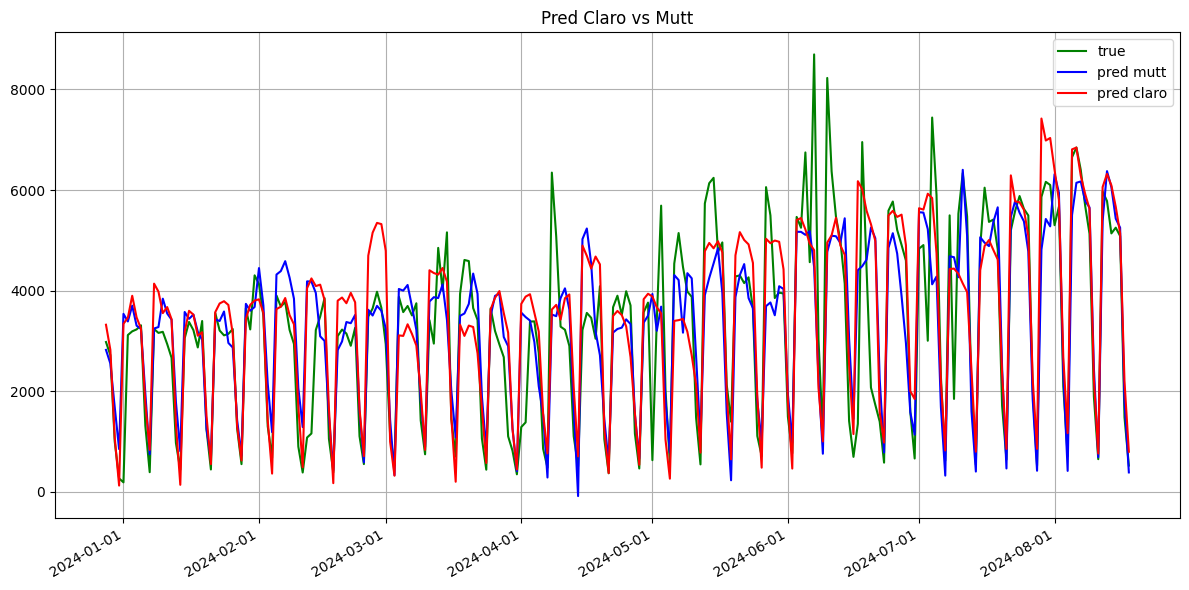

In [59]:
#  Graficar 'error' en el primer subgráfico
plt.figure(figsize=(12, 6)) 
plt.plot(df_claro['date'], df_claro['true'], color='green', label = "true")
plt.plot(df_claro['date'], df.filter(pl.col('date') >= df_claro['date'].min())['pred'], color='blue', label = "pred mutt")
plt.plot(df_claro['date'], df_claro['pred'], color='red', label = "pred claro")

# Mostrar la leyenda con los labels
plt.legend(loc='best')  # 'best' selecciona la mejor ubicación automática para la leyenda
plt.title('Pred Claro vs Mutt')
plt.grid(True)

# Mejorar el formato de la fecha en el eje x
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())
plt.gcf().autofmt_xdate()

# Mostrar la gráfica
plt.tight_layout()
plt.show()

## Calcular el error Ei = Ri - Pi

In [60]:
df_claro = df_claro.with_columns(
    (pl.col("true") - pl.col("pred")).alias("error")
)
print(df_claro)

shape: (235, 4)
┌────────────┬──────┬──────┬───────┐
│ date       ┆ true ┆ pred ┆ error │
│ ---        ┆ ---  ┆ ---  ┆ ---   │
│ date       ┆ i64  ┆ i64  ┆ i64   │
╞════════════╪══════╪══════╪═══════╡
│ 2023-12-28 ┆ 2977 ┆ 3321 ┆ -344  │
│ 2023-12-29 ┆ 2717 ┆ 2822 ┆ -105  │
│ 2023-12-30 ┆ 998  ┆ 1076 ┆ -78   │
│ 2023-12-31 ┆ 265  ┆ 123  ┆ 142   │
│ 2024-01-01 ┆ 187  ┆ 3339 ┆ -3152 │
│ …          ┆ …    ┆ …    ┆ …     │
│ 2024-08-14 ┆ 5137 ┆ 6094 ┆ -957  │
│ 2024-08-15 ┆ 5251 ┆ 5668 ┆ -417  │
│ 2024-08-16 ┆ 5086 ┆ 5141 ┆ -55   │
│ 2024-08-17 ┆ 1482 ┆ 2198 ┆ -716  │
│ 2024-08-18 ┆ 521  ┆ 796  ┆ -275  │
└────────────┴──────┴──────┴───────┘


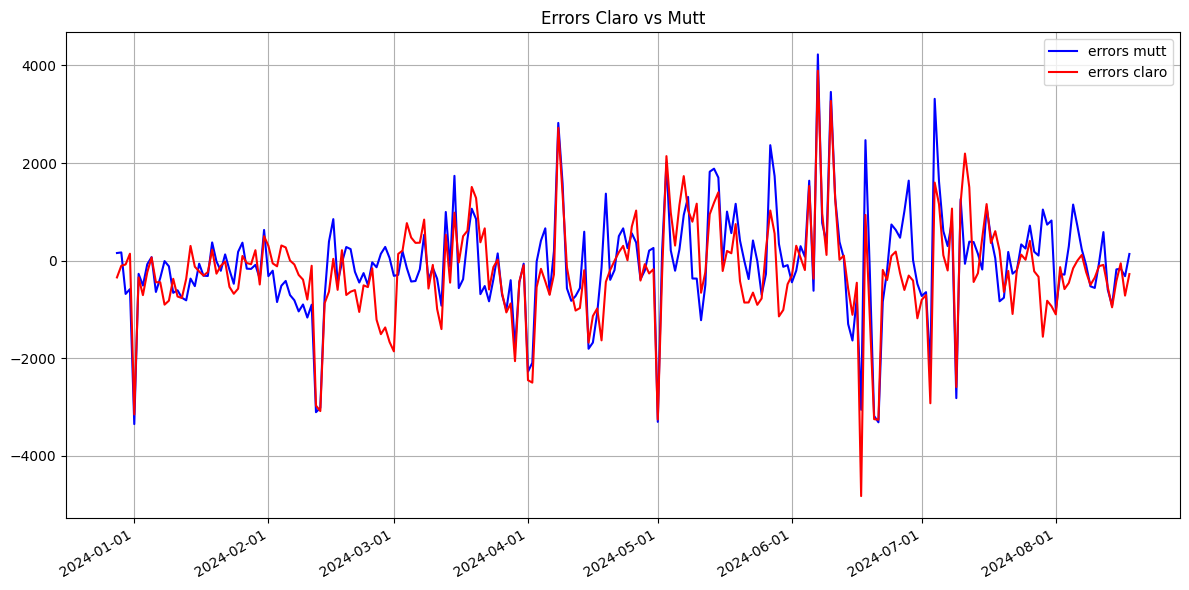

In [61]:
#  Graficar 'error' en el primer subgráfico
plt.figure(figsize=(12, 6)) 
plt.plot(df_claro['date'], df.filter(pl.col('date') >= df_claro['date'].min())['error'], color='blue', label = "errors mutt")
plt.plot(df_claro['date'], df_claro['error'], color='red', label = "errors claro")
# Mostrar la leyenda con los labels
plt.legend(loc='best')  # 'best' selecciona la mejor ubicación automática para la leyenda
plt.title('Errors Claro vs Mutt')
plt.grid(True)

# Mejorar el formato de la fecha en el eje x
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())
plt.gcf().autofmt_xdate()

# Mostrar la gráfica
plt.tight_layout()
plt.show()

In [62]:
print(df.filter(pl.col('date') >= df_claro['date'].min())['error'].describe()) ##errors mutt

shape: (9, 2)
┌────────────┬────────────┐
│ statistic  ┆ value      │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ count      ┆ 235.0      │
│ null_count ┆ 0.0        │
│ mean       ┆ -66.763455 │
│ std        ┆ 1053.89639 │
│ min        ┆ -3350.0415 │
│ 25%        ┆ -514.3384  │
│ 50%        ┆ -135.8398  │
│ 75%        ┆ 381.1337   │
│ max        ┆ 4226.332   │
└────────────┴────────────┘


In [63]:
print(df_claro['error'].describe()) ##errors claro

shape: (9, 2)
┌────────────┬─────────────┐
│ statistic  ┆ value       │
│ ---        ┆ ---         │
│ str        ┆ f64         │
╞════════════╪═════════════╡
│ count      ┆ 235.0       │
│ null_count ┆ 0.0         │
│ mean       ┆ -227.897872 │
│ std        ┆ 1043.190806 │
│ min        ┆ -4825.0     │
│ 25%        ┆ -641.0      │
│ 50%        ┆ -219.0      │
│ 75%        ┆ 214.0       │
│ max        ┆ 3892.0      │
└────────────┴─────────────┘


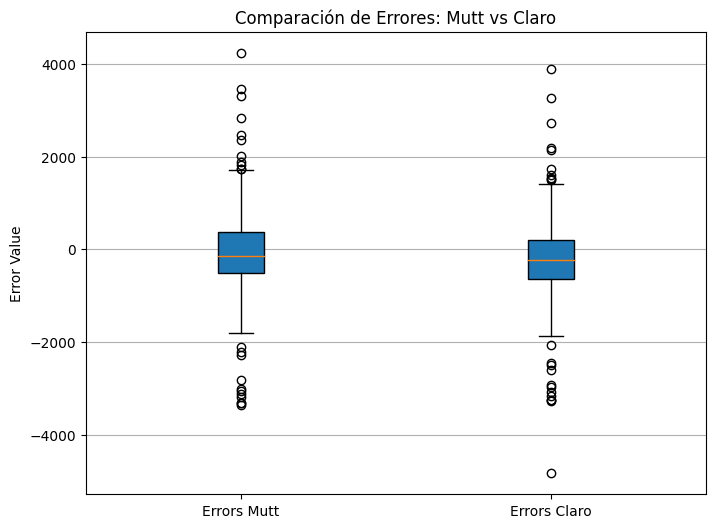

In [64]:
# Filtrar los datos para que ambos DataFrames tengan las mismas fechas
errors_mutt = df.filter(pl.col('date') >= df_claro['date'].min())['error'].to_pandas()
errors_claro = df_claro['error'].to_pandas()

# Crear el boxplot comparativo
plt.figure(figsize=(8, 6))
plt.boxplot([errors_mutt, errors_claro], labels=["Errors Mutt", "Errors Claro"], patch_artist=True)

# Añadir título y etiquetas
plt.title("Comparación de Errores: Mutt vs Claro")
plt.ylabel("Error Value")

# Mostrar la cuadrícula para mayor claridad
plt.grid(axis='y')

# Mostrar el gráfico
plt.show()

## Feriados

### Variación del feriado

In [65]:
## Le agregamos el tipo de feriado
df_claro = df_claro.join(df_feriado, on='date', how='left')

# Asignar 1 como valor por defecto para la columna `promedio_variacion`
df_claro = df_claro.with_columns(pl.lit(1).alias('promedio_variacion'))

# Iterar sobre cada fila en el DataFrame con las variaciones
for row in df_variacion.iter_rows(named=True):
    variacion = row['promedio_variacion']
    fechas = row['dates']  # Es una lista de listas de fechas

    # Iterar sobre las listas de fechas dentro de 'dates'
    for lista_fechas in fechas:
        for fecha in lista_fechas:
            # Asignar la variación a la fecha correspondiente en df_original
            df_claro = df_claro.with_columns(
                pl.when(pl.col('date') == fecha).then(variacion).otherwise(pl.col('promedio_variacion')).alias('promedio_variacion')
            )

# Revisa el DataFrame final
print(df_claro)

shape: (237, 7)
┌────────────┬──────┬──────┬───────┬────────────────┬──────────────┬────────────────────┐
│ date       ┆ true ┆ pred ┆ error ┆ holiday_name   ┆ tipo_feriado ┆ promedio_variacion │
│ ---        ┆ ---  ┆ ---  ┆ ---   ┆ ---            ┆ ---          ┆ ---                │
│ date       ┆ i64  ┆ i64  ┆ i64   ┆ str            ┆ i64          ┆ f64                │
╞════════════╪══════╪══════╪═══════╪════════════════╪══════════════╪════════════════════╡
│ 2023-12-28 ┆ 2977 ┆ 3321 ┆ -344  ┆ null           ┆ 0            ┆ 1.0                │
│ 2023-12-29 ┆ 2717 ┆ 2822 ┆ -105  ┆ null           ┆ 0            ┆ 1.0                │
│ 2023-12-30 ┆ 998  ┆ 1076 ┆ -78   ┆ null           ┆ -1           ┆ 1.0                │
│ 2023-12-31 ┆ 265  ┆ 123  ┆ 142   ┆ New Year's Eve ┆ 1            ┆ 54.880224          │
│ 2024-01-01 ┆ 187  ┆ 3339 ┆ -3152 ┆ New Year's Day ┆ 1            ┆ 74.926052          │
│ …          ┆ …    ┆ …    ┆ …     ┆ …              ┆ …            ┆ …              

##### Tratamos los repetidos

In [66]:
df_tipo1

date,true,pred,error,holiday_name,tipo_feriado,promedio_variacion
date,i64,f64,f64,str,i64,f64
2019-12-25,231,4509.064,-4278.064,"""Christmas Day""",1,75.138578
2019-12-31,1460,3858.5183,-2398.5183,"""New Year's Eve""",1,54.880224
2020-01-01,232,3568.2732,-3336.2732,"""New Year's Day""",1,74.926052
2020-02-24,1180,4639.808,-3459.808,"""Carnival / Shrove Monday""",1,69.199888
2020-02-25,1376,4608.4014,-3232.4014,"""Carnival / Shrove Tuesday / Pa…",1,68.770195
…,…,…,…,…,…,…
2024-05-25,1109,1807.101,-698.101,"""National Day/May 1810 Revoluti…",1,61.965546
2024-06-17,1350,4406.583,-3056.583,"""Commemoration of General Don M…",1,23.582495
2024-06-20,2071,5253.38,-3182.38,"""Flag Day""",1,51.313973


In [67]:
# Filtrar para mantener solo las filas con tipo de feriado 1 si existe al menos uno
df_tipo1 = df_claro.filter(pl.col('tipo_feriado') == 1)
#print(df_tipo1.filter(pl.col('date') == date(2024,6,17)))

# Crear una columna que indique si hay al menos un tipo de feriado 1 para cada fecha
df_min = df_claro.with_columns(
    pl.col('tipo_feriado').min().over('date').alias('tipo_feriado_min')
)
#print(df_min.filter(pl.col('date') == date(2024,6,17)))

# Si no hay tipo de feriado 1, tomar el promedio y concatenar nombres de las filas con tipo de feriado 2
df_tipo2 = df_min.filter(pl.col('tipo_feriado_min') == 2).group_by('date').agg(
    [
        pl.first('true').alias('true'),
        pl.first('pred').alias('pred'),
        pl.first('error').alias('error'),
        #pl.first('holiday_name').alias('holiday_name'),
        pl.col('holiday_name').unique().cast(str).str.join(' / ').alias('holiday_name'),  # Concatenar strings con '/'
        pl.first('tipo_feriado').alias('tipo_feriado'),
        pl.mean('promedio_variacion').alias('promedio_variacion')
    ]
)
#print(df_tipo2.filter(pl.col('date') == date(2020,4,9)))
df_final_claro = pl.concat([df_tipo1, df_tipo2])
print(df_final_claro)

shape: (26, 7)
┌────────────┬──────┬──────┬───────┬───────────────────────────┬──────────────┬────────────────────┐
│ date       ┆ true ┆ pred ┆ error ┆ holiday_name              ┆ tipo_feriado ┆ promedio_variacion │
│ ---        ┆ ---  ┆ ---  ┆ ---   ┆ ---                       ┆ ---          ┆ ---                │
│ date       ┆ i64  ┆ i64  ┆ i64   ┆ str                       ┆ i64          ┆ f64                │
╞════════════╪══════╪══════╪═══════╪═══════════════════════════╪══════════════╪════════════════════╡
│ 2023-12-31 ┆ 265  ┆ 123  ┆ 142   ┆ New Year's Eve            ┆ 1            ┆ 54.880224          │
│ 2024-01-01 ┆ 187  ┆ 3339 ┆ -3152 ┆ New Year's Day            ┆ 1            ┆ 74.926052          │
│ 2024-02-12 ┆ 1078 ┆ 4048 ┆ -2970 ┆ Carnival / Shrove Monday  ┆ 1            ┆ 69.199888          │
│ 2024-02-13 ┆ 1159 ┆ 4242 ┆ -3083 ┆ Carnival / Shrove Tuesday ┆ 1            ┆ 68.770195          │
│            ┆      ┆      ┆       ┆ / Pa…                     ┆            

In [68]:
# Filtrar filas que están en el primer DataFrame pero no en el segundo
df_faltantes = df_claro.join(df_final_claro, on='date', how='anti')
df_concatenado = pl.concat([df_final_claro, df_faltantes])
df_claro = df_concatenado.sort('date')
print(df_claro)
print(len(df_claro) == len(df_claro['date'].unique())) #ya no tenemos repetidos

shape: (235, 7)
┌────────────┬──────┬──────┬───────┬────────────────┬──────────────┬────────────────────┐
│ date       ┆ true ┆ pred ┆ error ┆ holiday_name   ┆ tipo_feriado ┆ promedio_variacion │
│ ---        ┆ ---  ┆ ---  ┆ ---   ┆ ---            ┆ ---          ┆ ---                │
│ date       ┆ i64  ┆ i64  ┆ i64   ┆ str            ┆ i64          ┆ f64                │
╞════════════╪══════╪══════╪═══════╪════════════════╪══════════════╪════════════════════╡
│ 2023-12-28 ┆ 2977 ┆ 3321 ┆ -344  ┆ null           ┆ 0            ┆ 1.0                │
│ 2023-12-29 ┆ 2717 ┆ 2822 ┆ -105  ┆ null           ┆ 0            ┆ 1.0                │
│ 2023-12-30 ┆ 998  ┆ 1076 ┆ -78   ┆ null           ┆ -1           ┆ 1.0                │
│ 2023-12-31 ┆ 265  ┆ 123  ┆ 142   ┆ New Year's Eve ┆ 1            ┆ 54.880224          │
│ 2024-01-01 ┆ 187  ┆ 3339 ┆ -3152 ┆ New Year's Day ┆ 1            ┆ 74.926052          │
│ …          ┆ …    ┆ …    ┆ …     ┆ …              ┆ …            ┆ …              

In [69]:
print(f"Tenemos {len(df_claro.filter(pl.col('tipo_feriado') == 1))} feriados de tipo 1")
print(f"Tenemos {len(df_claro.filter(pl.col('tipo_feriado') == 2))} feriados de tipo 2")

print(f"Tenemos {len(df_claro.filter(pl.col('tipo_feriado') == 1)) + len(df_claro.filter(pl.col('tipo_feriado') == 2))} feriados en total")

Tenemos 13 feriados de tipo 1
Tenemos 13 feriados de tipo 2
Tenemos 26 feriados en total


In [70]:
print(len(df_claro.filter(pl.col('tipo_feriado') == 1)) + len(df_claro.filter(pl.col('tipo_feriado') == 2)) + len(df_claro.filter(pl.col('tipo_feriado') == -1)))
#Pareciera tener mas sentido analizar viendo los fin de semanas

88


Vemos que los datos de claro son pocos, son menos de un año, algo asi como 8 meses. Vemos que tenemos datos nada más que de 26 feriados, podemos pensar en dejar 6 feriados para testear, es decir, algo como el 22% de los feriados que tenemos. Sin embargo, esto tendrá más sentido cuando análicemos agregando los fines de semana. Veamos que fechas corresponde entonces para tener los últimos 6 feriados separados. 

In [71]:
print(df_final_claro.sort('date').tail(6))

shape: (6, 7)
┌────────────┬──────┬──────┬───────┬───────────────────────────┬──────────────┬────────────────────┐
│ date       ┆ true ┆ pred ┆ error ┆ holiday_name              ┆ tipo_feriado ┆ promedio_variacion │
│ ---        ┆ ---  ┆ ---  ┆ ---   ┆ ---                       ┆ ---          ┆ ---                │
│ date       ┆ i64  ┆ i64  ┆ i64   ┆ str                       ┆ i64          ┆ f64                │
╞════════════╪══════╪══════╪═══════╪═══════════════════════════╪══════════════╪════════════════════╡
│ 2024-06-17 ┆ 1350 ┆ 6175 ┆ -4825 ┆ Commemoration of General  ┆ 1            ┆ 23.582495          │
│            ┆      ┆      ┆       ┆ Don M…                    ┆              ┆                    │
│ 2024-06-20 ┆ 2071 ┆ 5320 ┆ -3249 ┆ Flag Day                  ┆ 1            ┆ 51.313973          │
│ 2024-06-21 ┆ 1727 ┆ 4987 ┆ -3260 ┆ Tourist Bridge Holiday    ┆ 1            ┆ 60.457534          │
│ 2024-07-08 ┆ 5496 ┆ 4429 ┆ 1067  ┆ Muharram/New Year         ┆ 2           

Por lo que tenemos que tomar 2024-06-17 como fecha de corte entre train y test para quedarnos con 6 feriados

### Predicción de errores

In [72]:
date_claro = date(2024,6,16)
X_train, X_test, y_train, y_test = split(['pred', 'tipo_feriado', 'promedio_variacion'], 'error', date_claro, df_claro)
y_pred_feriados_claro = lgbm_model(X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/home/mutt/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mutt/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mutt/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mutt/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed w

/home/mutt/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mutt/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mutt/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mutt/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed w

Mejores parámetros encontrados: {'num_leaves': 40, 'n_estimators': 400, 'max_depth': 10, 'learning_rate': 0.01}


/home/mutt/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [73]:
len(y_test)

63

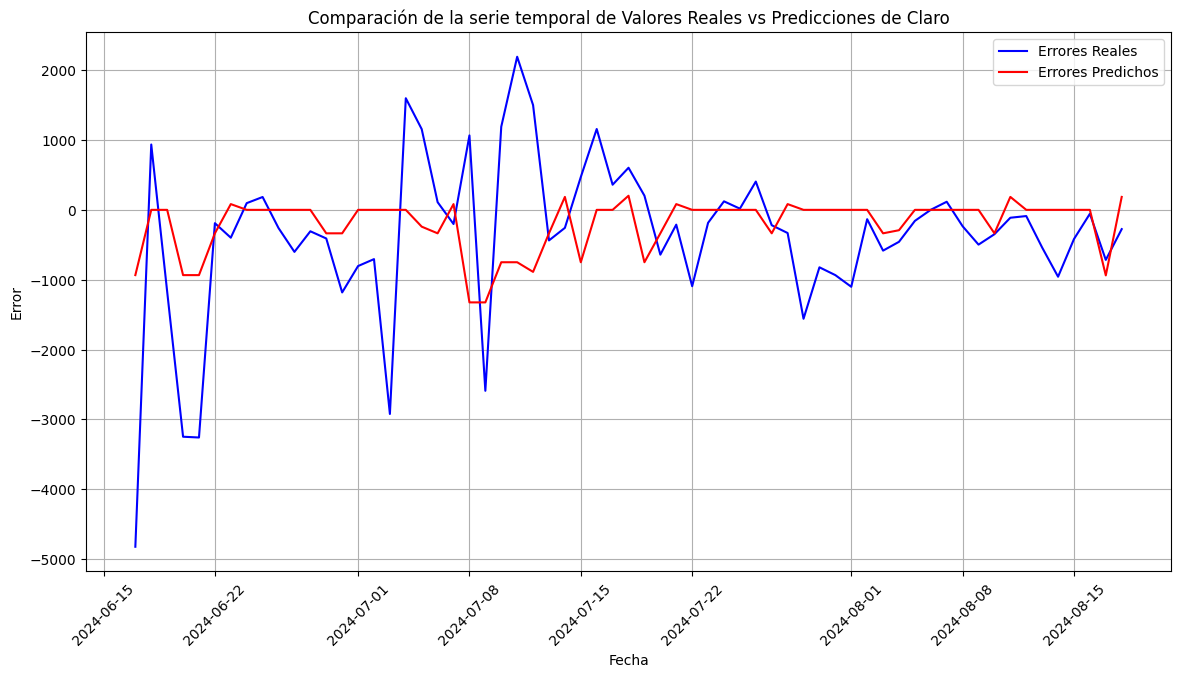

In [74]:
# Crear una serie de tiempo para las fechas correspondientes a y_test
dates_test = df_claro.filter(pl.col('date') > date_claro).select('date').to_numpy().ravel()

# Graficar la serie temporal
plt.figure(figsize=(14, 7))
plt.plot(dates_test, y_test, label='Errores Reales', color='blue')
plt.plot(dates_test, y_pred_feriados_claro, label='Errores Predichos', color='red')

plt.xlabel('Fecha')
plt.ylabel('Error')
plt.title('Comparación de la serie temporal de Valores Reales vs Predicciones de Claro')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

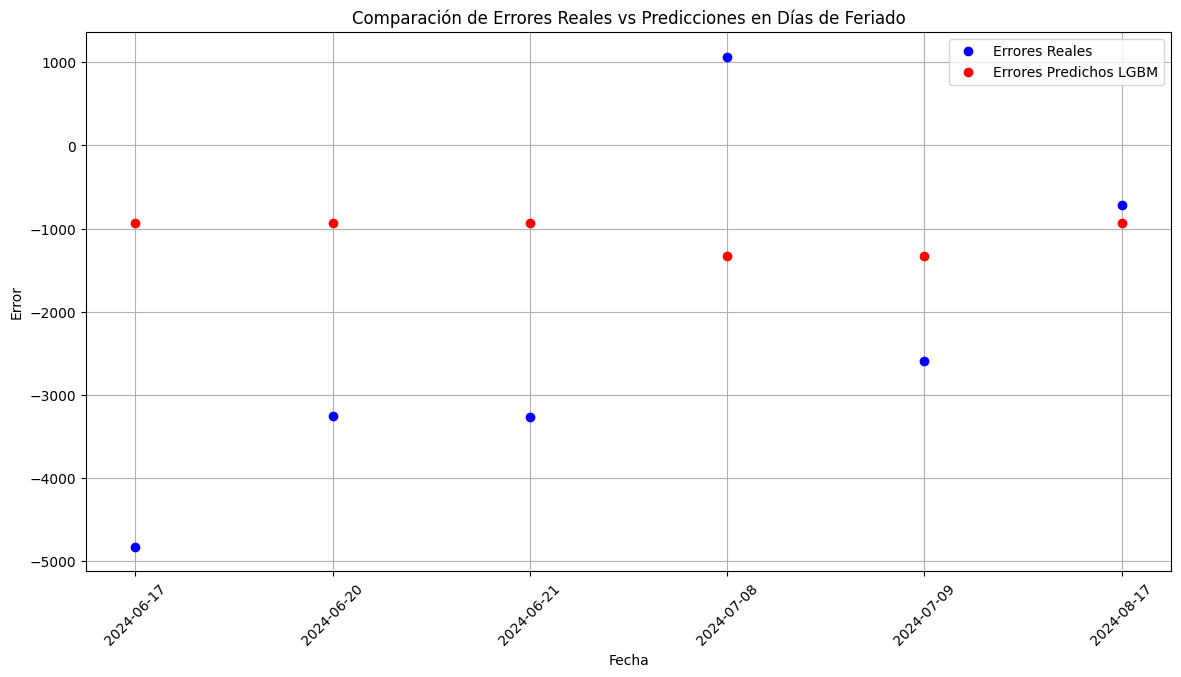

In [75]:
df_results_feriados_claro = df_con_resultados(df_claro, y_test, y_pred_feriados_claro, date_claro, 'feriados')
# Hacer un join para obtener solo los días de feriado (tipo_feriado == 1 o 2)
df_results_solo_feriados_claro = df_results_feriados_claro.join(
    df[['date', 'tipo_feriado']].filter((pl.col('tipo_feriado') == 1) | (pl.col('tipo_feriado') == 2)), 
    on='date', 
    how='inner'
)
plot_results(df_results_solo_feriados_claro, 'y_test', 'y_pred_feriados')

##### Comparamos para ver performance

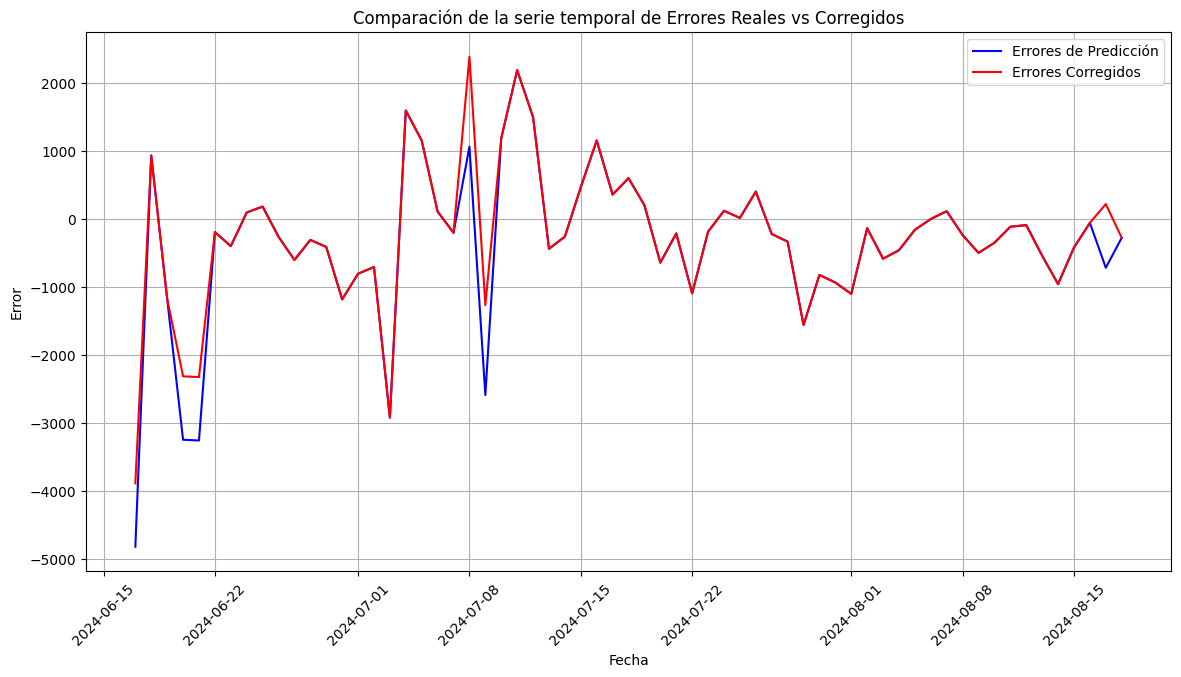

In [76]:
df_comparation_feriados_claro = df_comparation_para_feriados(df_claro, date_claro, df_results_solo_feriados_claro, 'feriados')
#print(df_comparation_feriados)
plot_errors(df_comparation_feriados_claro, 'feriados')

In [77]:
print(df_comparation_feriados_claro['error'].describe())

shape: (9, 2)
┌────────────┬─────────────┐
│ statistic  ┆ value       │
│ ---        ┆ ---         │
│ str        ┆ f64         │
╞════════════╪═════════════╡
│ count      ┆ 63.0        │
│ null_count ┆ 0.0         │
│ mean       ┆ -363.904762 │
│ std        ┆ 1158.877414 │
│ min        ┆ -4825.0     │
│ 25%        ┆ -641.0      │
│ 50%        ┆ -257.0      │
│ 75%        ┆ 117.0       │
│ max        ┆ 2194.0      │
└────────────┴─────────────┘


In [78]:
print(df_comparation_feriados_claro['error_corregido_feriados'].describe())

shape: (9, 2)
┌────────────┬──────────────┐
│ statistic  ┆ value        │
│ ---        ┆ ---          │
│ str        ┆ f64          │
╞════════════╪══════════════╡
│ count      ┆ 63.0         │
│ null_count ┆ 0.0          │
│ mean       ┆ -262.492236  │
│ std        ┆ 1045.130979  │
│ min        ┆ -3891.068181 │
│ 25%        ┆ -601.0       │
│ 50%        ┆ -234.0       │
│ 75%        ┆ 123.0        │
│ max        ┆ 2391.585362  │
└────────────┴──────────────┘


##### Agregamos fin de semana

In [79]:
print(df_results_feriados_claro) #son solo los feriados 1 o 2

shape: (63, 3)
┌────────────┬────────┬─────────────────┐
│ date       ┆ y_test ┆ y_pred_feriados │
│ ---        ┆ ---    ┆ ---             │
│ date       ┆ i64    ┆ f64             │
╞════════════╪════════╪═════════════════╡
│ 2024-06-17 ┆ -4825  ┆ -933.931819     │
│ 2024-06-18 ┆ 937    ┆ 0.937663        │
│ 2024-06-19 ┆ -1170  ┆ 0.937663        │
│ 2024-06-20 ┆ -3249  ┆ -933.931819     │
│ 2024-06-21 ┆ -3260  ┆ -933.931819     │
│ …          ┆ …      ┆ …               │
│ 2024-08-14 ┆ -957   ┆ 0.937663        │
│ 2024-08-15 ┆ -417   ┆ 0.937663        │
│ 2024-08-16 ┆ -55    ┆ 0.937663        │
│ 2024-08-17 ┆ -716   ┆ -938.022962     │
│ 2024-08-18 ┆ -275   ┆ 186.454431      │
└────────────┴────────┴─────────────────┘


shape: (23, 4)
┌────────────┬────────┬───────────────┬──────────────┐
│ date       ┆ y_test ┆ y_pred_findes ┆ tipo_feriado │
│ ---        ┆ ---    ┆ ---           ┆ ---          │
│ date       ┆ i64    ┆ f64           ┆ i64          │
╞════════════╪════════╪═══════════════╪══════════════╡
│ 2024-06-17 ┆ -4825  ┆ -933.931819   ┆ 1            │
│ 2024-06-20 ┆ -3249  ┆ -933.931819   ┆ 1            │
│ 2024-06-21 ┆ -3260  ┆ -933.931819   ┆ 1            │
│ 2024-06-22 ┆ -190   ┆ -335.2702     ┆ -1           │
│ 2024-06-23 ┆ -398   ┆ 83.346262     ┆ -1           │
│ …          ┆ …      ┆ …             ┆ …            │
│ 2024-08-04 ┆ -457   ┆ -290.781448   ┆ -1           │
│ 2024-08-10 ┆ -348   ┆ -335.2702     ┆ -1           │
│ 2024-08-11 ┆ -112   ┆ 186.454431    ┆ -1           │
│ 2024-08-17 ┆ -716   ┆ -938.022962   ┆ 2            │
│ 2024-08-18 ┆ -275   ┆ 186.454431    ┆ -1           │
└────────────┴────────┴───────────────┴──────────────┘


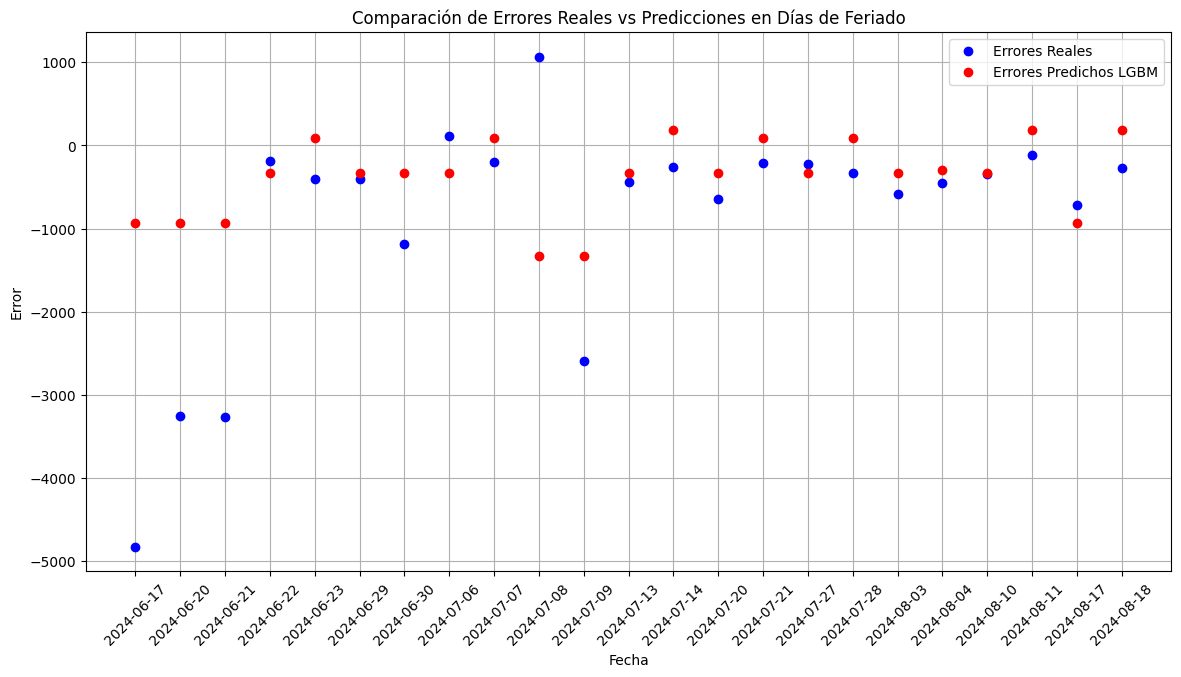

In [80]:
df_results_findes_claro = df_results_feriados_claro.join(
    df_claro[['date', 'tipo_feriado']].filter(pl.col('tipo_feriado') != 0), 
    on='date', 
    how='inner'
)
df_results_findes_claro = df_results_findes_claro.rename({"y_pred_feriados": "y_pred_findes"})
print(df_results_findes_claro)
plot_results(df_results_findes_claro, 'y_test', 'y_pred_findes')

In [81]:
df_comparation_findes_claro =  df_comparation_para_feriados(df_claro, date_claro, df_results_findes_claro, 'findes')
#print(df_comparation_findes_claro)
#plot_errors(df_comparation_findes, 'findes')

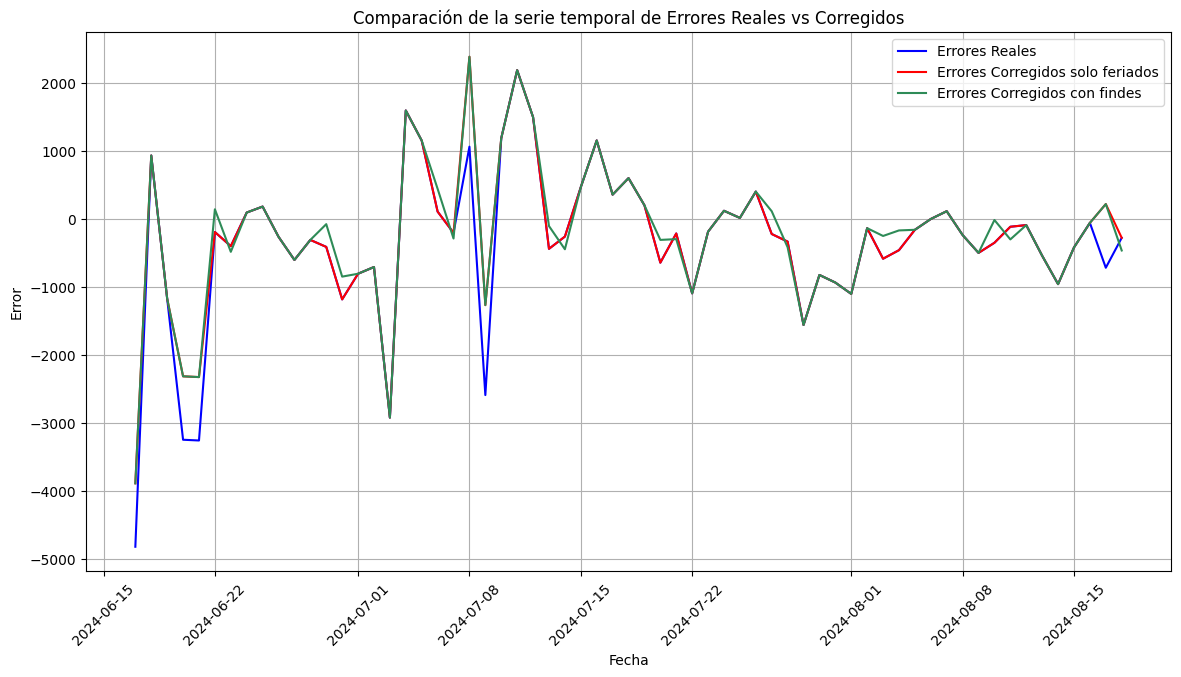

In [82]:
# Graficar la serie temporal
plt.figure(figsize=(14, 7))
plt.plot(df_comparation_feriados_claro['date'], df_comparation_feriados_claro['error'], label='Errores Reales', color='blue')
plt.plot(df_comparation_feriados_claro['date'], df_comparation_feriados_claro['error_corregido_feriados'], label='Errores Corregidos solo feriados', color='red')
plt.plot(df_comparation_findes_claro['date'], df_comparation_findes_claro['error_corregido_findes'], label='Errores Corregidos con findes', color='seagreen')

plt.xlabel('Fecha')
plt.ylabel('Error')
plt.title('Comparación de la serie temporal de Errores Reales vs Corregidos')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [83]:
print(df_comparation_findes_claro['error_corregido_findes'].describe())

shape: (9, 2)
┌────────────┬──────────────┐
│ statistic  ┆ value        │
│ ---        ┆ ---          │
│ str        ┆ f64          │
╞════════════╪══════════════╡
│ count      ┆ 63.0         │
│ null_count ┆ 0.0          │
│ mean       ┆ -224.151523  │
│ std        ┆ 1044.781661  │
│ min        ┆ -3891.068181 │
│ 25%        ┆ -539.0       │
│ 50%        ┆ -185.0       │
│ 75%        ┆ 185.0        │
│ max        ┆ 2391.585362  │
└────────────┴──────────────┘


# Promediamos predicciones de MUTT y Claro

In [88]:
print(df_claro)

shape: (235, 7)
┌────────────┬──────┬──────┬───────┬────────────────┬──────────────┬────────────────────┐
│ date       ┆ true ┆ pred ┆ error ┆ holiday_name   ┆ tipo_feriado ┆ promedio_variacion │
│ ---        ┆ ---  ┆ ---  ┆ ---   ┆ ---            ┆ ---          ┆ ---                │
│ date       ┆ i64  ┆ i64  ┆ i64   ┆ str            ┆ i64          ┆ f64                │
╞════════════╪══════╪══════╪═══════╪════════════════╪══════════════╪════════════════════╡
│ 2023-12-28 ┆ 2977 ┆ 3321 ┆ -344  ┆ null           ┆ 0            ┆ 1.0                │
│ 2023-12-29 ┆ 2717 ┆ 2822 ┆ -105  ┆ null           ┆ 0            ┆ 1.0                │
│ 2023-12-30 ┆ 998  ┆ 1076 ┆ -78   ┆ null           ┆ -1           ┆ 1.0                │
│ 2023-12-31 ┆ 265  ┆ 123  ┆ 142   ┆ New Year's Eve ┆ 1            ┆ 54.880224          │
│ 2024-01-01 ┆ 187  ┆ 3339 ┆ -3152 ┆ New Year's Day ┆ 1            ┆ 74.926052          │
│ …          ┆ …    ┆ …    ┆ …     ┆ …              ┆ …            ┆ …              

In [102]:
df_ambos = df_claro.join(df[['date','pred']], on="date", how="left")
df_ambos = df_ambos.rename({"pred": "pred_claro", "pred_right": "pred_mutt"})
df_ambos = df_ambos.with_columns(
   ((pl.col("pred_claro") + pl.col("pred_mutt"))/2).alias("pred")
)
df_ambos = df_ambos.drop('error')
print(df_ambos)

shape: (235, 8)
┌────────────┬──────┬────────────┬─────────────┬─────────────┬────────────┬───────────┬────────────┐
│ date       ┆ true ┆ pred_claro ┆ holiday_nam ┆ tipo_feriad ┆ promedio_v ┆ pred_mutt ┆ pred       │
│ ---        ┆ ---  ┆ ---        ┆ e           ┆ o           ┆ ariacion   ┆ ---       ┆ ---        │
│ date       ┆ i64  ┆ i64        ┆ ---         ┆ ---         ┆ ---        ┆ f64       ┆ f64        │
│            ┆      ┆            ┆ str         ┆ i64         ┆ f64        ┆           ┆            │
╞════════════╪══════╪════════════╪═════════════╪═════════════╪════════════╪═══════════╪════════════╡
│ 2023-12-28 ┆ 2977 ┆ 3321       ┆ null        ┆ 0           ┆ 1.0        ┆ 2820.8037 ┆ 3070.90185 │
│ 2023-12-29 ┆ 2717 ┆ 2822       ┆ null        ┆ 0           ┆ 1.0        ┆ 2548.9336 ┆ 2685.4668  │
│ 2023-12-30 ┆ 998  ┆ 1076       ┆ null        ┆ -1          ┆ 1.0        ┆ 1680.5461 ┆ 1378.27305 │
│ 2023-12-31 ┆ 265  ┆ 123        ┆ New Year's  ┆ 1           ┆ 54.880224  ┆

## Calcular el error Ei = Ri - Pi

In [103]:
df_ambos = df_ambos.with_columns(
    (pl.col("true") - pl.col("pred")).alias("error")
)
print(df_ambos)

shape: (235, 9)
┌────────────┬──────┬────────────┬────────────┬───┬────────────┬───────────┬───────────┬───────────┐
│ date       ┆ true ┆ pred_claro ┆ holiday_na ┆ … ┆ promedio_v ┆ pred_mutt ┆ pred      ┆ error     │
│ ---        ┆ ---  ┆ ---        ┆ me         ┆   ┆ ariacion   ┆ ---       ┆ ---       ┆ ---       │
│ date       ┆ i64  ┆ i64        ┆ ---        ┆   ┆ ---        ┆ f64       ┆ f64       ┆ f64       │
│            ┆      ┆            ┆ str        ┆   ┆ f64        ┆           ┆           ┆           │
╞════════════╪══════╪════════════╪════════════╪═══╪════════════╪═══════════╪═══════════╪═══════════╡
│ 2023-12-28 ┆ 2977 ┆ 3321       ┆ null       ┆ … ┆ 1.0        ┆ 2820.8037 ┆ 3070.9018 ┆ -93.90185 │
│            ┆      ┆            ┆            ┆   ┆            ┆           ┆ 5         ┆           │
│ 2023-12-29 ┆ 2717 ┆ 2822       ┆ null       ┆ … ┆ 1.0        ┆ 2548.9336 ┆ 2685.4668 ┆ 31.5332   │
│ 2023-12-30 ┆ 998  ┆ 1076       ┆ null       ┆ … ┆ 1.0        ┆ 1680.5461 

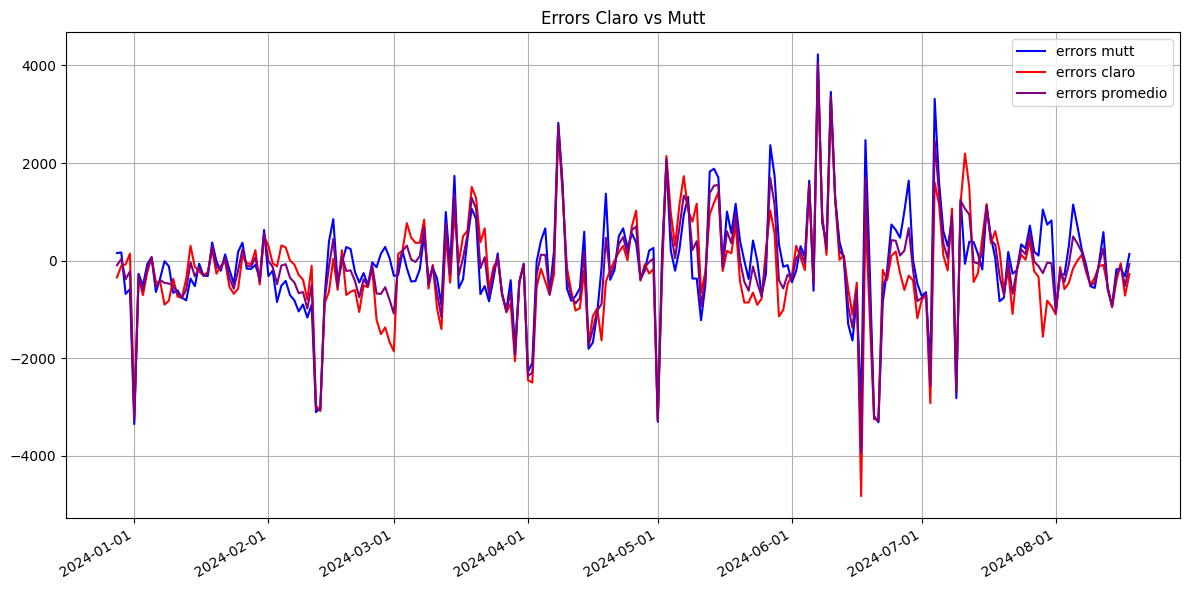

In [104]:
#  Graficar 'error' en el primer subgráfico
plt.figure(figsize=(12, 6)) 
plt.plot(df_claro['date'], df.filter(pl.col('date') >= df_claro['date'].min())['error'], color='blue', label = "errors mutt")
plt.plot(df_claro['date'], df_claro['error'], color='red', label = "errors claro")
plt.plot(df_ambos['date'], df_ambos['error'], color='purple', label = "errors promedio")
# Mostrar la leyenda con los labels
plt.legend(loc='best')  # 'best' selecciona la mejor ubicación automática para la leyenda
plt.title('Errors Claro vs Mutt')
plt.grid(True)

# Mejorar el formato de la fecha en el eje x
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())
plt.gcf().autofmt_xdate()

# Mostrar la gráfica
plt.tight_layout()
plt.show()

In [105]:
print(df_ambos['error'].describe()) ##errors promedios

shape: (9, 2)
┌────────────┬─────────────┐
│ statistic  ┆ value       │
│ ---        ┆ ---         │
│ str        ┆ f64         │
╞════════════╪═════════════╡
│ count      ┆ 235.0       │
│ null_count ┆ 0.0         │
│ mean       ┆ -147.330664 │
│ std        ┆ 993.296031  │
│ min        ┆ -3940.7915  │
│ 25%        ┆ -520.51685  │
│ 50%        ┆ -130.98975  │
│ 75%        ┆ 206.8585    │
│ max        ┆ 4059.166    │
└────────────┴─────────────┘


## Feriados

### Predicción de errores

In [106]:
X_train, X_test, y_train, y_test = split(['pred', 'tipo_feriado', 'promedio_variacion'], 'error', date_claro, df_ambos)
y_pred_feriados_ambos = lgbm_model(X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/home/mutt/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mutt/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mutt/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mutt/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed w

/home/mutt/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mutt/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mutt/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mutt/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed w

Mejores parámetros encontrados: {'num_leaves': 20, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.09000000000000001}


/home/mutt/.pyenv/versions/3.8.2/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [100]:
df_results_feriados_ambos = df_con_resultados(df_ambos, y_test, y_pred_feriados_ambos, date_claro, 'feriados')
# Hacer un join para obtener solo los días de feriado (tipo_feriado == 1 o 2)
df_results_solo_feriados_ambos = df_results_feriados_ambos.join(
    df[['date', 'tipo_feriado']].filter((pl.col('tipo_feriado') == 1) | (pl.col('tipo_feriado') == 2)), 
    on='date', 
    how='inner'
)

##### Comparamos para ver performance

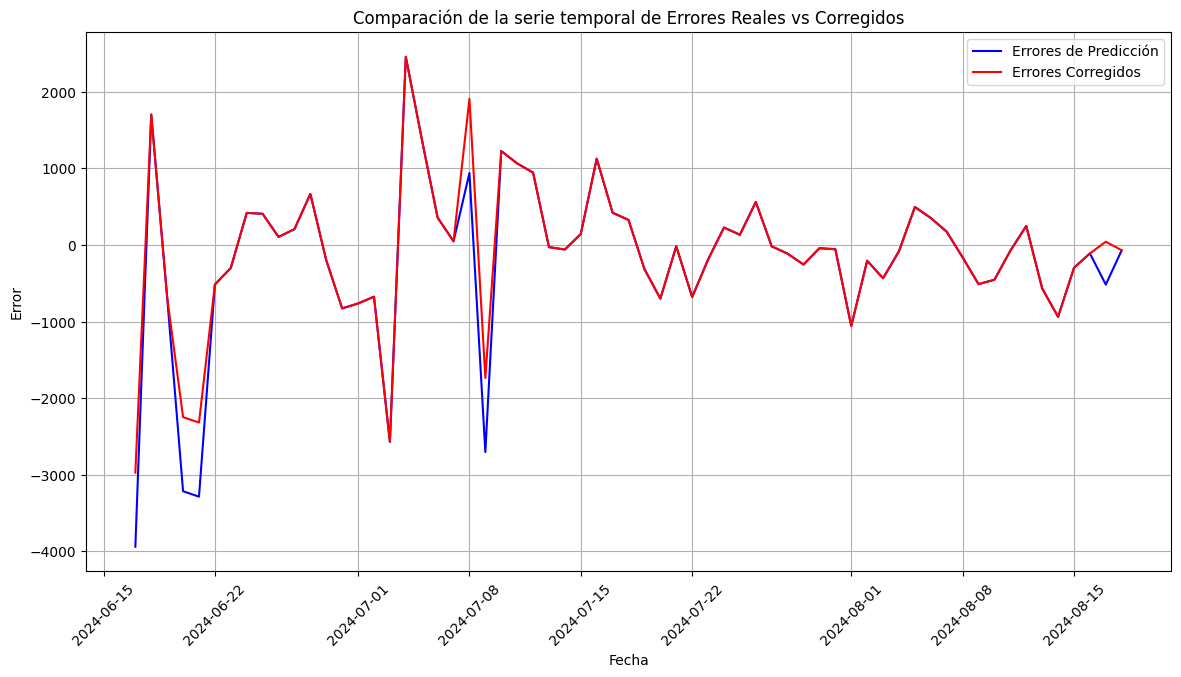

In [109]:
df_comparation_feriados_ambos = df_comparation_para_feriados(df_ambos, date_claro, df_results_solo_feriados_ambos, 'feriados')
#print(df_comparation_feriados)
plot_errors(df_comparation_feriados_ambos, 'feriados')

In [110]:
print(df_comparation_feriados_ambos['error'].describe())

shape: (9, 2)
┌────────────┬─────────────┐
│ statistic  ┆ value       │
│ ---        ┆ ---         │
│ str        ┆ f64         │
╞════════════╪═════════════╡
│ count      ┆ 63.0        │
│ null_count ┆ 0.0         │
│ mean       ┆ -182.481344 │
│ std        ┆ 1095.247368 │
│ min        ┆ -3940.7915  │
│ 25%        ┆ -511.2025   │
│ 50%        ┆ -69.16919   │
│ 75%        ┆ 352.4195    │
│ max        ┆ 2457.969    │
└────────────┴─────────────┘


In [111]:
print(df_comparation_feriados_ambos['error_corregido_feriados'].describe())

shape: (9, 2)
┌────────────┬─────────────┐
│ statistic  ┆ value       │
│ ---        ┆ ---         │
│ str        ┆ f64         │
╞════════════╪═════════════╡
│ count      ┆ 63.0        │
│ null_count ┆ 0.0         │
│ mean       ┆ -96.795601  │
│ std        ┆ 956.057     │
│ min        ┆ -2973.08306 │
│ 25%        ┆ -453.93775  │
│ 50%        ┆ -59.76575   │
│ 75%        ┆ 352.4195    │
│ max        ┆ 2457.969    │
└────────────┴─────────────┘


##### Agregamos fin de semana

In [113]:
print(df_results_feriados_ambos) #son solo los feriados 1 o 2

shape: (63, 3)
┌────────────┬─────────────┬─────────────────┐
│ date       ┆ y_test      ┆ y_pred_feriados │
│ ---        ┆ ---         ┆ ---             │
│ date       ┆ f64         ┆ f64             │
╞════════════╪═════════════╪═════════════════╡
│ 2024-06-17 ┆ -3940.7915  ┆ -967.70844      │
│ 2024-06-18 ┆ 1703.048    ┆ 232.298026      │
│ 2024-06-19 ┆ -684.431    ┆ 232.298026      │
│ 2024-06-20 ┆ -3215.69    ┆ -967.70844      │
│ 2024-06-21 ┆ -3286.69875 ┆ -967.70844      │
│ …          ┆ …           ┆ …               │
│ 2024-08-14 ┆ -938.557    ┆ 232.298026      │
│ 2024-08-15 ┆ -298.33     ┆ 232.298026      │
│ 2024-08-16 ┆ -110.2212   ┆ 232.298026      │
│ 2024-08-17 ┆ -517.25615  ┆ -559.659612     │
│ 2024-08-18 ┆ -69.16919   ┆ 46.875665       │
└────────────┴─────────────┴─────────────────┘


shape: (23, 4)
┌────────────┬─────────────┬───────────────┬──────────────┐
│ date       ┆ y_test      ┆ y_pred_findes ┆ tipo_feriado │
│ ---        ┆ ---         ┆ ---           ┆ ---          │
│ date       ┆ f64         ┆ f64           ┆ i64          │
╞════════════╪═════════════╪═══════════════╪══════════════╡
│ 2024-06-17 ┆ -3940.7915  ┆ -967.70844    ┆ 1            │
│ 2024-06-20 ┆ -3215.69    ┆ -967.70844    ┆ 1            │
│ 2024-06-21 ┆ -3286.69875 ┆ -967.70844    ┆ 1            │
│ 2024-06-22 ┆ -516.74635  ┆ -428.635771   ┆ -1           │
│ 2024-06-23 ┆ -299.7179   ┆ -65.082766    ┆ -1           │
│ …          ┆ …           ┆ …             ┆ …            │
│ 2024-08-04 ┆ -81.430665  ┆ 46.875665     ┆ -1           │
│ 2024-08-10 ┆ -453.93775  ┆ -915.27743    ┆ -1           │
│ 2024-08-11 ┆ -75.5719    ┆ 46.875665     ┆ -1           │
│ 2024-08-17 ┆ -517.25615  ┆ -559.659612   ┆ 2            │
│ 2024-08-18 ┆ -69.16919   ┆ 46.875665     ┆ -1           │
└────────────┴───────────

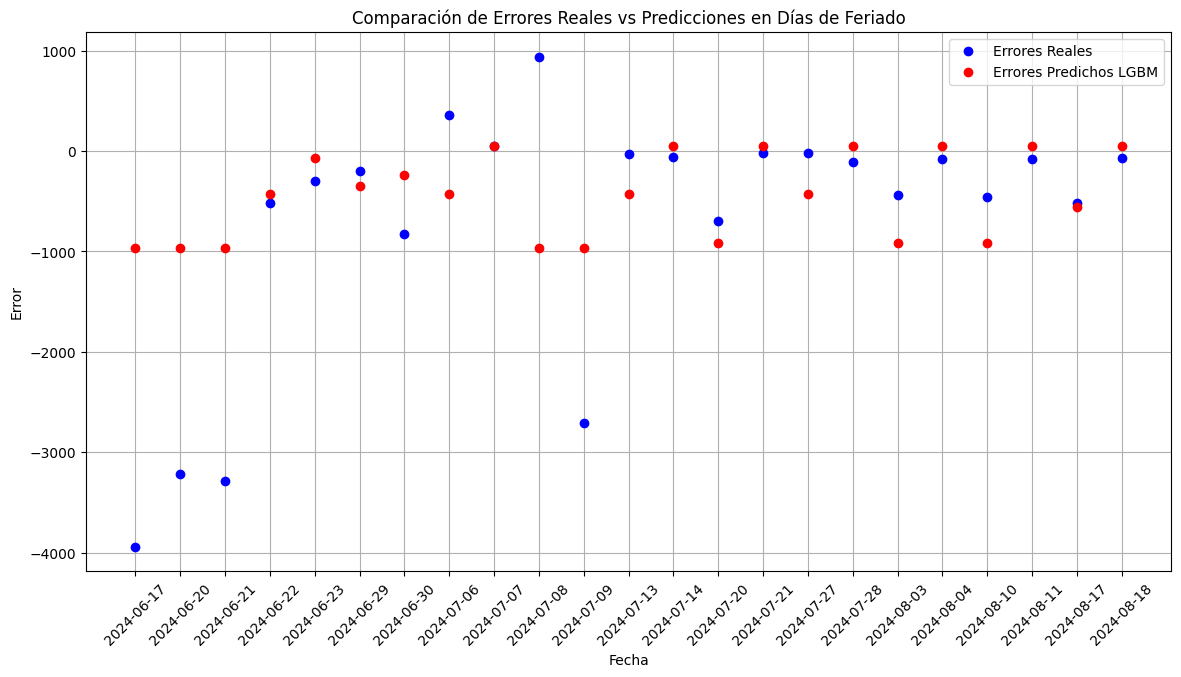

In [114]:
df_results_findes_ambos = df_results_feriados_ambos.join(
    df_ambos[['date', 'tipo_feriado']].filter(pl.col('tipo_feriado') != 0), 
    on='date', 
    how='inner'
)
df_results_findes_ambos = df_results_findes_ambos.rename({"y_pred_feriados": "y_pred_findes"})
print(df_results_findes_ambos)
plot_results(df_results_findes_ambos, 'y_test', 'y_pred_findes')

In [115]:
df_comparation_findes_ambos =  df_comparation_para_feriados(df_ambos, date_claro, df_results_findes_ambos, 'findes')
#print(df_comparation_findes_claro)
#plot_errors(df_comparation_findes, 'findes')

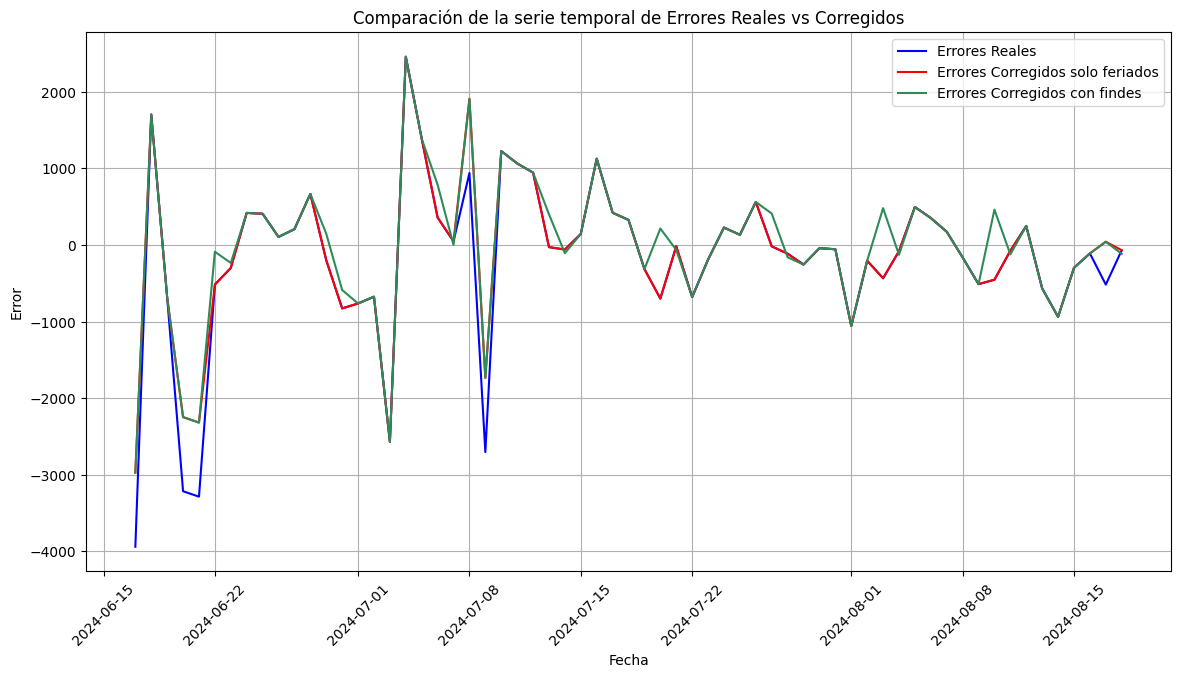

In [117]:
# Graficar la serie temporal
plt.figure(figsize=(14, 7))
plt.plot(df_comparation_findes_ambos['date'], df_comparation_findes_ambos['error'], label='Errores Reales', color='blue')
plt.plot(df_comparation_feriados_ambos['date'], df_comparation_feriados_ambos['error_corregido_feriados'], label='Errores Corregidos solo feriados', color='red')
plt.plot(df_comparation_findes_ambos['date'], df_comparation_findes_ambos['error_corregido_findes'], label='Errores Corregidos con findes', color='seagreen')

plt.xlabel('Fecha')
plt.ylabel('Error')
plt.title('Comparación de la serie temporal de Errores Reales vs Corregidos')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [118]:
print(df_comparation_findes_ambos['error_corregido_findes'].describe())

shape: (9, 2)
┌────────────┬─────────────┐
│ statistic  ┆ value       │
│ ---        ┆ ---         │
│ str        ┆ f64         │
╞════════════╪═════════════╡
│ count      ┆ 63.0        │
│ null_count ┆ 0.0         │
│ mean       ┆ -20.868024  │
│ std        ┆ 959.280998  │
│ min        ┆ -2973.08306 │
│ 25%        ┆ -255.7665   │
│ 50%        ┆ 0.966255    │
│ 75%        ┆ 418.866     │
│ max        ┆ 2457.969    │
└────────────┴─────────────┘


Comparemos para las predicciones de MUTT, Claro y el promedio de ambas

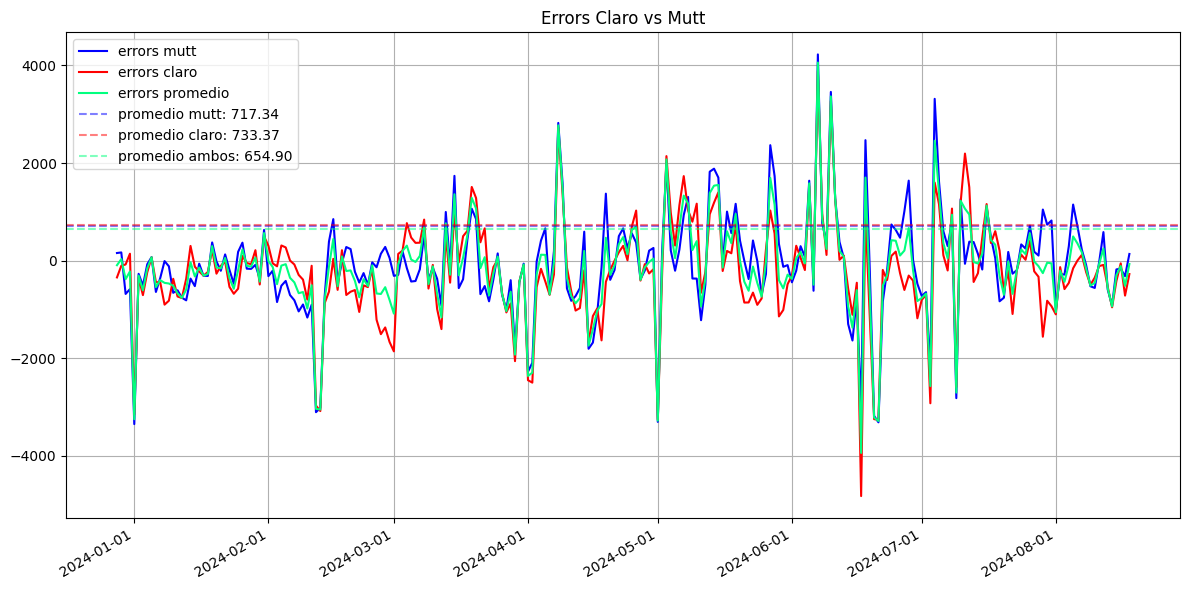

In [157]:
# Crear la figura
plt.figure(figsize=(12, 6))

# Graficar los errores
plt.plot(df_claro['date'], df.filter(pl.col('date') >= df_claro['date'].min())['error'], color='blue', label="errors mutt")
plt.plot(df_claro['date'], df_claro['error'], color='red', label="errors claro")
plt.plot(df_ambos['date'], df_ambos['error'], color='springgreen', label="errors promedio")

# Calcular los promedios de error
mutt_mean = abs(df.filter(pl.col('date') >= df_claro['date'].min())['error']).mean()
claro_mean = abs(df_claro['error']).mean()
ambos_mean = abs(df_ambos['error']).mean()

# Agregar líneas horizontales para los promedios
plt.axhline(y=mutt_mean, color='blue', linestyle='--', alpha=0.5, label=f"promedio mutt: {mutt_mean:.2f}")
plt.axhline(y=claro_mean, color='red', linestyle='--', alpha=0.5, label=f"promedio claro: {claro_mean:.2f}")
plt.axhline(y=ambos_mean, color='springgreen', linestyle='--', alpha=0.5, label=f"promedio ambos: {ambos_mean:.2f}")

# Mostrar la leyenda
plt.legend(loc='best')

# Título y formato del gráfico
plt.title('Errors Claro vs Mutt')
plt.grid(True)

# Mejorar el formato de la fecha en el eje x
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())
plt.gcf().autofmt_xdate()

# Ajustar el layout y mostrar la gráfica
plt.tight_layout()
plt.show()

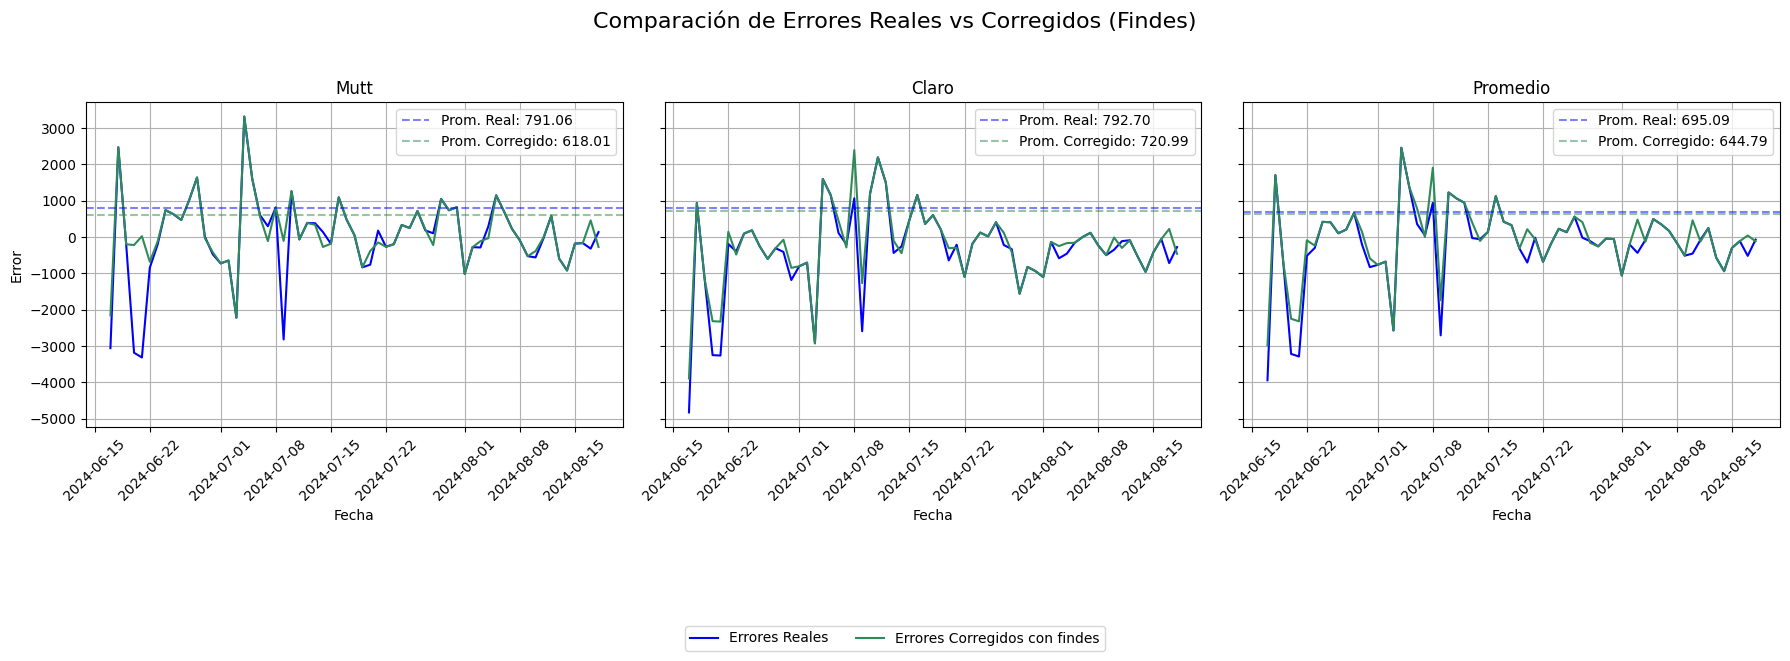

In [176]:
# Crear la figura con subplots: 1 fila y 3 columnas
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)  # sharey=True sincroniza el eje Y

# Listas de DataFrames y títulos para recorrer dinámicamente
dataframes = [
    ("Mutt", df_comparation_findes.filter(pl.col('date') >= df_comparation_findes_claro['date'].min())),
    ("Claro", df_comparation_findes_claro),
    ("Promedio", df_comparation_findes_ambos)
]

# Recorrer los DataFrames y graficar en cada subplot
for ax, (title, dfs) in zip(axes, dataframes):
    # Graficar errores reales y corregidos por fines de semana
    ax.plot(dfs['date'], dfs['error'], color='blue')
    ax.plot(dfs['date'], dfs['error_corregido_findes'], color='seagreen')

    # Calcular y graficar líneas de promedio
    promedio_error = abs(dfs['error']).mean()
    promedio_corregido = abs(dfs['error_corregido_findes']).mean()
    ax.axhline(promedio_error, color='blue', linestyle='--', alpha=0.5, label=f'Prom. Real: {promedio_error:.2f}')
    ax.axhline(promedio_corregido, color='seagreen', linestyle='--', alpha=0.5, label=f'Prom. Corregido: {promedio_corregido:.2f}')

    # Configuración del subplot
    ax.set_title(f'{title}')
    ax.set_xlabel('Fecha')
    ax.tick_params(axis='x', rotation=45)  # Rotar las etiquetas de fecha para mayor claridad
    ax.grid(True)

    # Añadir la leyenda específica dentro de cada subplot
    ax.legend(loc='upper right')

# Etiqueta del eje Y solo en el primer subplot
axes[0].set_ylabel('Error')

# Ajustar layout y añadir una leyenda global en la parte inferior para errores generales
fig.suptitle('Comparación de Errores Reales vs Corregidos (Findes)', fontsize=16)
fig.legend(['Errores Reales', 'Errores Corregidos con findes'], loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.1))

# Ajustar el layout para evitar solapamientos
plt.tight_layout(rect=[0, 0.1, 1, 0.95])  # Reservar espacio para la leyenda inferior

# Mostrar la gráfica
plt.show()


# Mixeamos

Probamos aplicar el corrector entrenado con los datos de feriados de nuestro predictor a la serie de claro/promedio.

## Claro

Ya tenemos una función que se encarga de esto, de aplicar el corrector a los feriados, ahora loq ue hacemos es pasar los resultados del modelo entrenado con nuestros datos (df_results_findes) añ df de claro y al de promedios. Esta funcion tenia la fecha de limite de test, acá queremos ver la performance en toda la serie, por lo que usamos cualquier fecha anterior a 28/12/2023 que es el minimo de los datos de Claro.

In [179]:
df_corrector_claro =  df_comparation_para_feriados(df_claro, date(2023,7,31), df_results_findes, 'findes')
print(df_corrector_claro)

shape: (235, 10)
┌────────────┬──────┬──────┬───────┬───┬──────────────┬──────────────┬──────────────┬──────────────┐
│ date       ┆ true ┆ pred ┆ error ┆ … ┆ promedio_var ┆ y_pred_finde ┆ pred_corregi ┆ error_correg │
│ ---        ┆ ---  ┆ ---  ┆ ---   ┆   ┆ iacion       ┆ s            ┆ do_findes    ┆ ido_findes   │
│ date       ┆ i64  ┆ i64  ┆ i64   ┆   ┆ ---          ┆ ---          ┆ ---          ┆ ---          │
│            ┆      ┆      ┆       ┆   ┆ f64          ┆ f64          ┆ f64          ┆ f64          │
╞════════════╪══════╪══════╪═══════╪═══╪══════════════╪══════════════╪══════════════╪══════════════╡
│ 2023-12-28 ┆ 2977 ┆ 3321 ┆ -344  ┆ … ┆ 1.0          ┆ null         ┆ 3321.0       ┆ -344.0       │
│ 2023-12-29 ┆ 2717 ┆ 2822 ┆ -105  ┆ … ┆ 1.0          ┆ null         ┆ 2822.0       ┆ -105.0       │
│ 2023-12-30 ┆ 998  ┆ 1076 ┆ -78   ┆ … ┆ 1.0          ┆ 43.343823    ┆ 1119.343823  ┆ -121.343823  │
│ 2023-12-31 ┆ 265  ┆ 123  ┆ 142   ┆ … ┆ 54.880224    ┆ -481.642686  ┆ -35

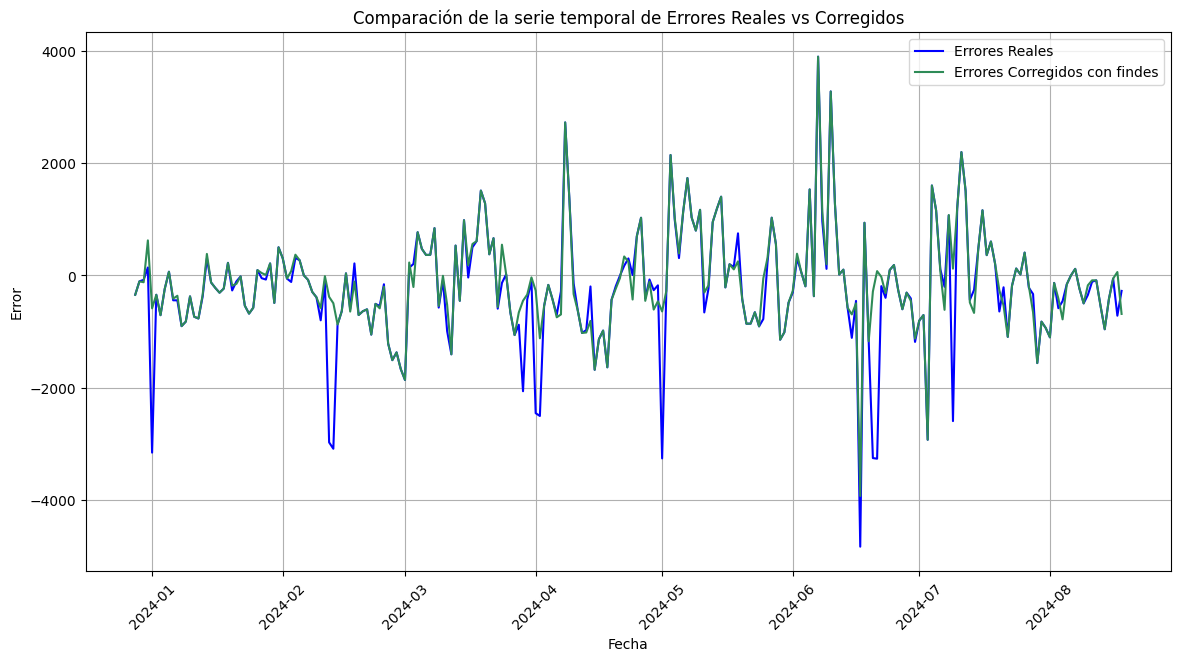

In [180]:
# Graficar la serie temporal
plt.figure(figsize=(14, 7))
plt.plot(df_corrector_claro['date'], df_corrector_claro['error'], label='Errores Reales', color='blue')
plt.plot(df_corrector_claro['date'], df_corrector_claro['error_corregido_findes'], label='Errores Corregidos con findes', color='seagreen')

plt.xlabel('Fecha')
plt.ylabel('Error')
plt.title('Comparación de la serie temporal de Errores Reales vs Corregidos')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

## Promedio

In [185]:
df_corrector_promedio =  df_comparation_para_feriados(df_ambos, date(2023,7,31), df_results_findes, 'findes')
print(df_corrector_promedio.columns)

['date', 'true', 'pred_claro', 'holiday_name', 'tipo_feriado', 'promedio_variacion', 'pred_mutt', 'pred', 'error', 'y_pred_findes', 'pred_corregido_findes', 'error_corregido_findes']


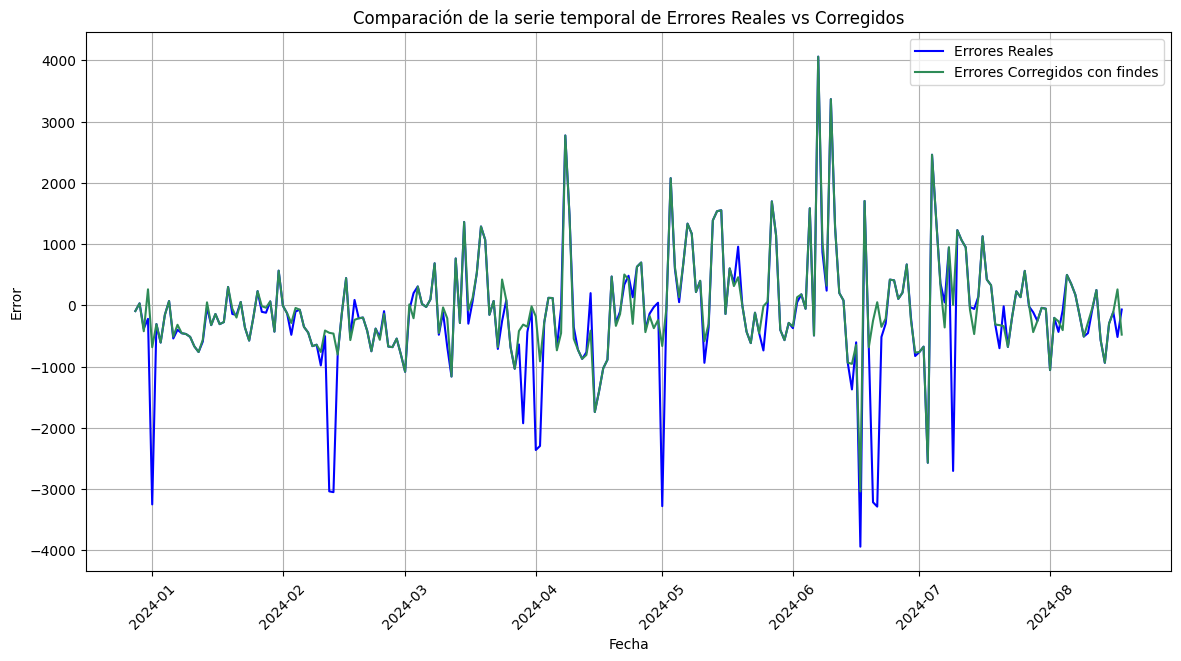

In [183]:
# Graficar la serie temporal
plt.figure(figsize=(14, 7))
plt.plot(df_corrector_promedio['date'], df_corrector_promedio['error'], label='Errores Reales', color='blue')
plt.plot(df_corrector_promedio['date'], df_corrector_promedio['error_corregido_findes'], label='Errores Corregidos con findes', color='seagreen')

plt.xlabel('Fecha')
plt.ylabel('Error')
plt.title('Comparación de la serie temporal de Errores Reales vs Corregidos')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

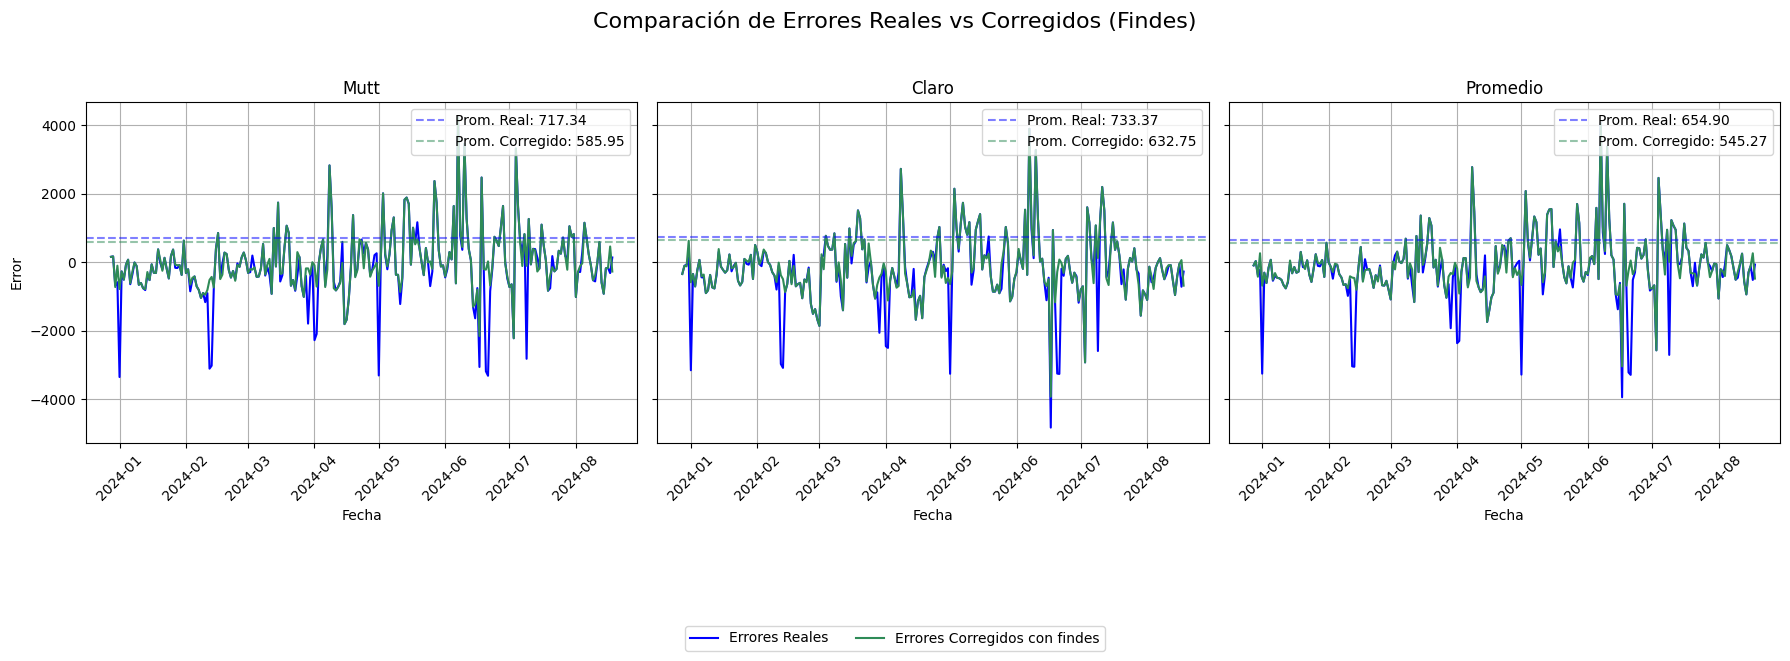

In [189]:
# Crear la figura con subplots: 1 fila y 3 columnas
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)  # sharey=True sincroniza el eje Y

# Listas de DataFrames y títulos para recorrer dinámicamente
dataframes = [
    ("Mutt", df_comparation_findes.filter(pl.col('date') >= df_corrector_claro['date'].min())),
    ("Claro", df_corrector_claro),
    ("Promedio", df_corrector_promedio)
]

# Recorrer los DataFrames y graficar en cada subplot
for ax, (title, dfs) in zip(axes, dataframes):
    # Graficar errores reales y corregidos por fines de semana
    ax.plot(dfs['date'], dfs['error'], color='blue')
    ax.plot(dfs['date'], dfs['error_corregido_findes'], color='seagreen')

    # Calcular y graficar líneas de promedio
    promedio_error = abs(dfs['error']).mean()
    promedio_corregido = abs(dfs['error_corregido_findes']).mean()
    ax.axhline(promedio_error, color='blue', linestyle='--', alpha=0.5, label=f'Prom. Real: {promedio_error:.2f}')
    ax.axhline(promedio_corregido, color='seagreen', linestyle='--', alpha=0.5, label=f'Prom. Corregido: {promedio_corregido:.2f}')

    # Configuración del subplot
    ax.set_title(f'{title}')
    ax.set_xlabel('Fecha')
    ax.tick_params(axis='x', rotation=45)  # Rotar las etiquetas de fecha para mayor claridad
    ax.grid(True)

    # Añadir la leyenda específica dentro de cada subplot
    ax.legend(loc='upper right')

# Etiqueta del eje Y solo en el primer subplot
axes[0].set_ylabel('Error')

# Ajustar layout y añadir una leyenda global en la parte inferior para errores generales
fig.suptitle('Comparación de Errores Reales vs Corregidos (Findes)', fontsize=16)
fig.legend(['Errores Reales', 'Errores Corregidos con findes'], loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.1))

# Ajustar el layout para evitar solapamientos
plt.tight_layout(rect=[0, 0.1, 1, 0.95])  # Reservar espacio para la leyenda inferior

# Mostrar la gráfica
plt.show()


O podemos ver las fechas que habíamos usado para tests, así comparamos con lo que nos dió más arriba

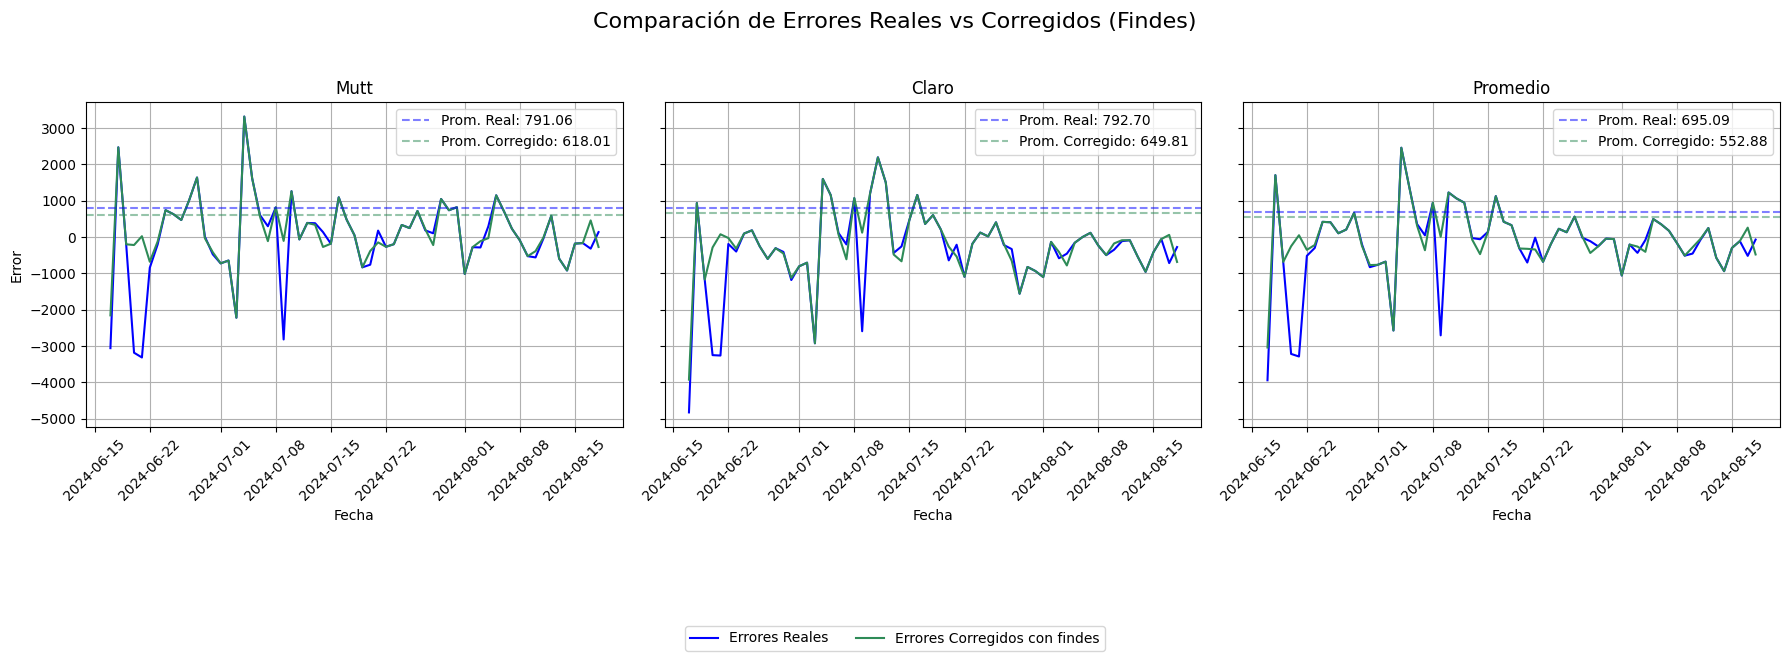

In [190]:
# Crear la figura con subplots: 1 fila y 3 columnas
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)  # sharey=True sincroniza el eje Y

# Listas de DataFrames y títulos para recorrer dinámicamente
dataframes = [
    ("Mutt", df_comparation_findes.filter(pl.col('date') >= df_comparation_findes_claro['date'].min())),
    ("Claro", df_corrector_claro.filter(pl.col('date') >= df_comparation_findes_claro['date'].min())),
    ("Promedio", df_corrector_promedio.filter(pl.col('date') >= df_comparation_findes_claro['date'].min()))
]

# Recorrer los DataFrames y graficar en cada subplot
for ax, (title, dfs) in zip(axes, dataframes):
    # Graficar errores reales y corregidos por fines de semana
    ax.plot(dfs['date'], dfs['error'], color='blue')
    ax.plot(dfs['date'], dfs['error_corregido_findes'], color='seagreen')

    # Calcular y graficar líneas de promedio
    promedio_error = abs(dfs['error']).mean()
    promedio_corregido = abs(dfs['error_corregido_findes']).mean()
    ax.axhline(promedio_error, color='blue', linestyle='--', alpha=0.5, label=f'Prom. Real: {promedio_error:.2f}')
    ax.axhline(promedio_corregido, color='seagreen', linestyle='--', alpha=0.5, label=f'Prom. Corregido: {promedio_corregido:.2f}')

    # Configuración del subplot
    ax.set_title(f'{title}')
    ax.set_xlabel('Fecha')
    ax.tick_params(axis='x', rotation=45)  # Rotar las etiquetas de fecha para mayor claridad
    ax.grid(True)

    # Añadir la leyenda específica dentro de cada subplot
    ax.legend(loc='upper right')

# Etiqueta del eje Y solo en el primer subplot
axes[0].set_ylabel('Error')

# Ajustar layout y añadir una leyenda global en la parte inferior para errores generales
fig.suptitle('Comparación de Errores Reales vs Corregidos (Findes)', fontsize=16)
fig.legend(['Errores Reales', 'Errores Corregidos con findes'], loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.1))

# Ajustar el layout para evitar solapamientos
plt.tight_layout(rect=[0, 0.1, 1, 0.95])  # Reservar espacio para la leyenda inferior

# Mostrar la gráfica
plt.show()


Lo que parecería ser la mejor opción: Entrenar el modelo para los errores de predicción de Mutt pero aplicar este corrector a los datos del promedio de ambas series.  